In [1]:
import pypsa
import atlite
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import holoviews as hv
import yaml
import os

with open('../pypsa-earth/config.SEA_base.yaml', 'r') as file:
    config = yaml.safe_load(file)

C:\Users\kunde\anaconda3\envs\esm-oet\Lib\site-packages\atlite\resource.py:20: DeprecationWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html

C:\Users\kunde\anaconda3\envs\esm-oet\Lib\site-packages\pkg_resources\__init__.py:3154: DeprecationWarning:

Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def rename_techs(label):
    if "H2" in label:
        label = "hydrogen storage"
    elif label == "solar":
        label = "solar PV"
    elif label == "offwind-ac":
        label = "offshore wind ac"
    elif label == "offwind-dc":
        label = "offshore wind dc"
    elif label == "onwind":
        label = "onshore wind"
    elif label == "ror":
        label = "hydroelectricity"
    elif label == "hydro":
        label = "hydroelectricity"
    elif label == "PHS":
        label = "hydroelectricity"
    elif "battery" in label:
        label = "battery storage"

    return label


preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "onshore wind",
        "offshore wind ac",
        "offshore wind dc",
        "solar PV",
        "solar thermal",
        "OCGT",
        "hydrogen storage",
        "battery storage",
    ]
)

## Single figure plot (capacity, cost and energy)

In [13]:
def plot_energy(infn, scenario_PyPSA, dec_name, config):

    df_all = pd.DataFrame()
    loads_df_all = pd.DataFrame()

    for year in infn:
        energy_df = pd.read_csv(infn[year], index_col=list(range(2)), header=[1, 2, 3])

        energy_df.columns = [year]
    
        df = energy_df.groupby(energy_df.index.get_level_values(1)).sum()

        loads_df = - energy_df.groupby(energy_df.index.get_level_values(0)).sum().query("index == 'loads'")/ 1e6

        # If there is any unique carrier to remove
        if "B2B" in df.index:
            df = df.drop("B2B")
    
        # convert MWh to TWh
        df = df / 1e6
    
        df = df.groupby(df.index.map(rename_techs)).sum()
        
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)

        if loads_df.empty:
            loads_df_all = loads_df
        else:
            loads_df_all = pd.concat([loads_df_all,loads_df],axis=1)
    
    new_index_energy = df_all.index.intersection(preferred_order).append(
        df.index.difference(preferred_order)
    )

    new_columns = df_all.columns.sort_values()

    fig_energy, ax = plt.subplots(figsize=(5.3, 4.7))
    #fig_energy.set_size_inches((8, 6))

    if new_index_energy.empty:
        print(f"No energy data to plot for country, no valid plot is generated")
        # create empty file to avoid issues with snakemake
        with open(infn[year], "w") as fp:
            pass
        return

    df_all.loc[new_index_energy, new_columns].T.plot(
        kind="area",
        ax=ax,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_energy],
        rot=90
    )

    loads_df_all.loc[:, new_columns].T.plot(
        kind="line",
        ax=ax,
        color="black",
        linestyle = 'dashed',
        rot=90
    )

    handles, labels = ax.get_legend_handles_labels()

    handles.reverse()
    labels.reverse()

    ax.set_ylabel("Energy [TWh/a]")

    ax.set_xlabel("")

    ax.set_title(f"{scenario_PyPSA}20XX")

    ax.grid(axis="y")
    ax.set_ylim([0, 7000])
    ax.set_xlim([2020,2050])

    ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.5))

    fig_energy.tight_layout()

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_energy_generation.png',bbox_inches='tight')

    return df_all

In [14]:
def plot_costs(infn, scenario_PyPSA, dec_name, config):

    df_all = pd.DataFrame()
    
    for year in infn:
        # For now ignore the simpl header
        cost_df = pd.read_csv(infn[year], index_col=list(range(3)), header=[1, 2, 3])

        #cost_df.columns = [str(infn[fn])]
    
        df = cost_df.groupby(cost_df.index.get_level_values(2)).sum()

        # If there is any unique carrier to remove
        if "B2B" in df.index:
            df = df.drop("B2B")

        # convert to billions
        df = df / 1e9
    
        df = df.groupby(df.index.map(rename_techs)).sum()

        df.columns = [year]
        
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)

    new_index_costs = df_all.index.intersection(preferred_order).append(
        df.index.difference(preferred_order)
    )

    new_columns = df_all.columns.sort_values()

    fig_costs, ax = plt.subplots(figsize=(5.3, 4.7))
    #fig_costs.set_size_inches((8, 6))

    #if new_index_costs.empty:
    #    print(f"No costs data to plot for country, no valid plot is generated")
    #    # create empty file to avoid issues with snakemake
    #    with open(fn, "w") as fp:
    #        pass
    #    return

    df_all.loc[new_index_costs, new_columns].T.plot(
        kind="area",
        ax=ax,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_costs],
        rot=90
    )

    handles, labels = ax.get_legend_handles_labels()

    handles.reverse()
    labels.reverse()

    ax.set_ylabel("System Cost [EUR billion per year]")

    ax.set_xlabel("")

    ax.set_title(f"{scenario_PyPSA}20XX")

    ax.grid(axis="y")
    ax.set_ylim([0, 600])
    ax.set_xlim([2020,2050])

    ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.5))

    fig_costs.tight_layout()

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_simple_system_cost.png',bbox_inches='tight')

    return df_all

In [15]:
def plot_capacity(infn, scenario_PyPSA, dec_name, config):

    df_all = pd.DataFrame()

    for year in infn:
        # For now ignore the simpl header
        cap_df = pd.read_csv(infn[year], index_col=list(range(2)), header=[1, 2, 3])

        cap_df["component"] = cap_df.index.get_level_values(0)

        cap_df = cap_df[cap_df.component == "generators"]

        cap_df = cap_df.drop(columns=["component"])
    
        df = cap_df.groupby(cap_df.index.get_level_values(1)).sum()

        # If there is any unique carrier to remove
        if "B2B" in df.index:
            df = df.drop("B2B")

        # convert to kW to MW
        df = df / 1e3
    
        df = df.groupby(df.index.map(rename_techs)).sum()

        df.columns = [year]
        
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)

    new_index_cap = df_all.index.intersection(preferred_order).append(
        df.index.difference(preferred_order)
    )

    new_columns = df_all.columns.sort_values()

    fig_cap, ax = plt.subplots(figsize=(5.3, 4.7))

    df_all.loc[new_index_cap, new_columns].T.plot(
        kind="area",
        ax=ax,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_cap],
        rot=90
    )

    ax.grid(axis="y")
    ax.set_ylim([0, 6000])
    ax.set_xlim([2020,2050])

    ax.set_ylabel("Capacity [MW]")
    handles, labels = ax.get_legend_handles_labels()
    handles.reverse()
    labels.reverse()
    ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.5))

    fig_cap.tight_layout()

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_energy_capacity.png',bbox_inches='tight')

    return df_all

## Readjust System Cost:

In [4]:
def summarize_system_cost(infn_costs):
    df_all = pd.DataFrame()
    
    for year in infn_costs:
        # For now ignore the simpl header
        cost_df = pd.read_csv(infn_costs[year], index_col=list(range(3)), header=[1, 2, 3])

        #cost_df.columns = [str(infn[fn])]
    
        df = cost_df.groupby(cost_df.index.get_level_values(2)).sum()

        # If there is any unique carrier to remove
        if "B2B" in df.index:
            df = df.drop("B2B")

        # convert to billions
        #df = df / 1e9
    
        df = df.groupby(df.index.map(rename_techs)).sum()

        df.columns = [year]
        
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)

    return df_all

def summarize_capacity(infn_cap):
    df_all = pd.DataFrame()

    for year in infn_cap:
        # For now ignore the simpl header
        cap_df = pd.read_csv(infn_cap[year], index_col=list(range(2)), header=[1, 2, 3])

        cap_df["component"] = cap_df.index.get_level_values(0)

        cap_df = cap_df#[cap_df.component == "generators"]

        cap_df = cap_df.drop(columns=["component"])
    
        df = cap_df.groupby(cap_df.index.get_level_values(1)).sum()

        # If there is any unique carrier to remove
        if "B2B" in df.index:
            df = df.drop("B2B")

        # convert to kW to MW
        #df = df / 1e3
    
        df = df.groupby(df.index.map(rename_techs)).sum()

        df.columns = [year]
        
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)

    return df_all

def summarize_carrier_cost(fn,columns):
    df_gen = pd.DataFrame(data={year: fn[year].generators.groupby("carrier")[columns].mean() for year in fn})
    df_store = pd.DataFrame(data={year: fn[year].stores.groupby("carrier")[columns].mean() for year in fn})
    if columns == "capital_cost":
        df_line = pd.DataFrame(data={year: fn[year].lines.groupby("carrier")[columns].mean() for year in fn}).rename(index={"AC":"lines"})
        df = pd.concat([df_gen,df_store,df_line])
        
    else:
        df = pd.concat([df_gen,df_store])
        
    df = df.groupby(df.index.map(rename_techs)).sum()
    return df

def readjust_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn):
    df_costs_raw = summarize_system_cost(scenario_infn_costs)
    df_cap = summarize_capacity(scenario_infn_cap)
    df_capital = summarize_carrier_cost(fn,"capital_cost")
    
    df_costs_base = df_costs_raw - (df_cap * df_capital)
    
    df_cap_change = df_cap.copy(deep=True)
    df_costs_clean = df_costs_base.copy(deep=True)
    
    for i in range(0,len(years)):
        df_cap_change[years[i]] = df_cap[years[i]] - df_cap_change[years[:i]].T.sum().T
    
    df_cost_positive = df_cap_change.clip(lower=0) * df_capital
    df_cost_negative = (df_cap_change.clip(upper=0).T * df_capital[2020]).T
    
    df_cost_yearly = df_cost_positive + df_cost_negative
    
    for i in range(0,len(years)):
        df_costs_clean[years[i]] = df_costs_base[years[i]] + df_cost_yearly[years[:i+1]].T.sum().T

    return df_costs_clean

def plot_costs_all(df_all, scenario_PyPSA, dec_name, config):

    new_index_costs = df_all.index.intersection(preferred_order).append(
        df.index.difference(preferred_order)
    )

    new_columns = df_all.columns.sort_values()

    fig_costs, ax = plt.subplots(figsize=(5.3, 4.7))

    df_all.loc[new_index_costs, new_columns].T.plot(
        kind="area",
        ax=ax,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_costs],
        rot=90
    )

    handles, labels = ax.get_legend_handles_labels()

    handles.reverse()
    labels.reverse()

    ax.set_ylabel("System Cost [EUR billion per year]")

    ax.set_xlabel("")

    ax.set_title(f"{scenario_PyPSA}20XX")

    ax.grid(axis="y")
    ax.set_ylim([0, 600])
    ax.set_xlim([2020,2050])

    ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.5))

    fig_costs.tight_layout()

## Combined Capacity and Energy

In [13]:
def plot_capacity_energy(infn_cap, infn_energy, scenario_PyPSA, dec_name, config):

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 3.5)) # (8, 3)
    df_all = pd.DataFrame()

    for year in infn_cap:
        # For now ignore the simpl header
        cap_df = pd.read_csv(infn_cap[year], index_col=list(range(2)), header=[1, 2, 3])

        cap_df["component"] = cap_df.index.get_level_values(0)

        cap_df = cap_df[cap_df.component == "generators"]

        cap_df = cap_df.drop(columns=["component"])
    
        df = cap_df.groupby(cap_df.index.get_level_values(1)).sum()

        # If there is any unique carrier to remove
        if "B2B" in df.index:
            df = df.drop("B2B")

        # convert from MW to GW
        df = df / 1e3
    
        df = df.groupby(df.index.map(rename_techs)).sum()

        df.columns = [year]
        
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)

    new_index_cap = df_all.index.intersection(preferred_order).append(
        df.index.difference(preferred_order)
    )

    new_columns = df_all.columns.sort_values()

    df_all.loc[new_index_cap, new_columns].T.plot(
        kind="area",
        ax=ax1,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_cap],
        rot=90,
        legend=False
    )

    ax1.grid(axis="y")
    ax1.set_ylim([0, 6000])
    ax1.set_xlim([2020,2050])

    ax1.set_ylabel("Capacity [GW]")

    ax1.set_title(f'{scenario_PyPSA}{dec_name}', 
                  loc='left', 
                  x=0.02, 
                  y=0.9,
                  fontsize=9
                 )

    df_all2 = df_all.copy(deep=True)

    ##########################################################################################

    df_all = pd.DataFrame()
    loads_df_all = pd.DataFrame()

    for year in infn_energy:
        energy_df = pd.read_csv(infn_energy[year], index_col=list(range(2)), header=[1, 2, 3])

        energy_df.columns = [year]
    
        df = energy_df.groupby(energy_df.index.get_level_values(1)).sum()

        loads_df = - energy_df.groupby(energy_df.index.get_level_values(0)).sum().query("index == 'loads'")/ 1e6

        # If there is any unique carrier to remove
        if "B2B" in df.index:
            df = df.drop("B2B")
    
        # convert MWh to TWh
        df = df / 1e6
    
        df = df.groupby(df.index.map(rename_techs)).sum()
        
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)

        if loads_df.empty:
            loads_df_all = loads_df
        else:
            loads_df_all = pd.concat([loads_df_all,loads_df],axis=1)
    
    new_index_energy = df_all.index.intersection(preferred_order).append(
        df.index.difference(preferred_order)
    )

    new_index_energy = new_index_energy.difference(["hydrogen storage"]) # Hydrogen plays a very small role. You can check it yourself by removing this code

    new_columns = df_all.columns.sort_values()

    if new_index_energy.empty:
        print(f"No energy data to plot for country, no valid plot is generated")
        # create empty file to avoid issues with snakemake
        with open(infn[year], "w") as fp:
            pass
        return

    df_all.loc[new_index_energy, new_columns].T.plot(
        kind="area",
        ax=ax2,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_energy],
        rot=90,
        legend=False
    )

    loads_df_all.loc[:, new_columns].T.plot(
        kind="line",
        ax=ax2,
        color="black",
        linestyle = 'dashed',
        rot=90,
        legend=False,
        linewidth=2
    )

    ax2.annotate('Load/a',
            xy=(2040, loads_df_all[2040]),  # theta, radius
            xytext=(2035, loads_df_all[2040]+1000),    # fraction, fraction
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth = 5),
            horizontalalignment='center',
            verticalalignment='top',
            )


    ax2.set_ylabel("Energy [TWh/a]")

    ax2.set_xlabel("")

    ax2.grid(axis="y")
    ax2.set_ylim([-500, 7000])
    ax2.set_xlim([2020,2050])

    ax2.set_title(f'{scenario_PyPSA}{dec_name}', 
                  loc='left', 
                  x=0.02, 
                  y=0.9,
                  fontsize=9
                 )

    fig.tight_layout()

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_capacity_energy.svg',bbox_inches='tight')

    return df_all

In [6]:
def check_emission_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn, scenario_PyPSA, dec_name, config):

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 3.5))#, gridspec_kw={'width_ratios': [1,1]})
    df_all = pd.DataFrame()

    for year in fn:
        n = fn[year]
        df = pd.DataFrame(data=(n.snapshot_weightings.generators @ n.generators_t.p) / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions))
        df = df.rename(columns={0:"tCO2"})
        df["carrier"] = n.generators.carrier
        df["bus"] = n.generators.bus
        df["country"] = df.bus.map(n.buses.country)

        df2 = pd.DataFrame(data={year:df.groupby(["carrier"]).tCO2.sum()/1e6})

        if df_all.empty:
            df_all = df2
        else:
            df_all = pd.concat([df_all,df2],axis=1)

    #new_index_emission = df_all.index.intersection(preferred_order).append(df_all.index.difference(preferred_order))
    new_index_emission = ['coal-USC', 'coal-SC', 'coal-CFB', 'coal-SubC', 'coal', 'lignite', 'CCGT']

    new_columns = df_all.columns.sort_values()

    df_all.loc[new_index_emission, new_columns].T.plot(
        kind="area",
        ax=ax1,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_emission],
        rot=90,
        legend=False
    )

    #handles, labels = ax.get_legend_handles_labels()

    #handles.reverse()
    #labels.reverse()

    #ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.4), frameon=False)

    df_color = pd.DataFrame(data = {"color" : [n.carriers.loc[c,"color"] for c in n.generators.query("carrier != 'load'").carrier.unique()]}, index = n.generators.query("carrier != 'load'").carrier.unique())

    df_color = df_color.groupby(df_color.index.map(rename_techs)).sum()

    df_color.index.intersection(preferred_order).append(df_color.index.difference(preferred_order))

    carrier_large = df_all.T.sum().to_frame("value").query("value > 10").index
    df_color = df_color.T[carrier_large].T
    df_color = df_color.reindex(index=df_color.index[::-1])

    #pypsa.plot.add_legend_patches(ax=ax1, colors = df_color.color, labels = df_color.index,
    #                             legend_kw = {'loc':"center left",'bbox_to_anchor':(1, 0.5), 'frameon':False, 'ncol':1, 'title':"Emission Source", 
    #                                          'title_fontproperties':{'weight':'bold'}})

    ax1.set_ylabel("CO2eq Emissions [MtCO2 per year]")

    ax1.set_xlabel("")

    ax1.grid(axis="y")
    #ax1.set_ylim([0, 1200])
    ax1.set_ylim([0, 2000])
    ax1.set_xlim([2020, 2050])

    ax1.set_title(f'{scenario_PyPSA}{dec_name}', 
                  loc='left', 
                  x=0.02, 
                  y=0.9,
                  fontsize=9
                 )

    ############################################################################################################################

    df_all = readjust_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn) / 1e9
    
    new_index_costs = df_all.index.intersection(preferred_order).append(
        df_all.index.difference(preferred_order)
    )

    new_columns = df_all.columns.sort_values()

    df_all.loc[new_index_costs, new_columns].T.plot(
        kind="area",
        ax=ax2,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_costs],
        rot=90,
        legend=False
    )

    #handles, labels = ax.get_legend_handles_labels()

    #handles.reverse()
    #labels.reverse()

    ax2.set_ylabel("System Cost [EUR billion per year]")

    ax2.set_xlabel("")

    #ax2.set_title(f"{scenario_PyPSA}20XX")

    ax2.grid(axis="y")
    ax2.set_ylim([0, 700])
    ax2.set_xlim([2020,2050])

    #ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.5))

    ax2.set_title(f'{scenario_PyPSA}{dec_name}', 
                  loc='left', 
                  x=0.02, 
                  y=0.9,
                  fontsize=9
                 )
    
    fig.tight_layout()

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_emission_system_cost.svg',bbox_inches='tight')

    return df_all
    

## Stagnant Tech Business as usual AIMS:

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


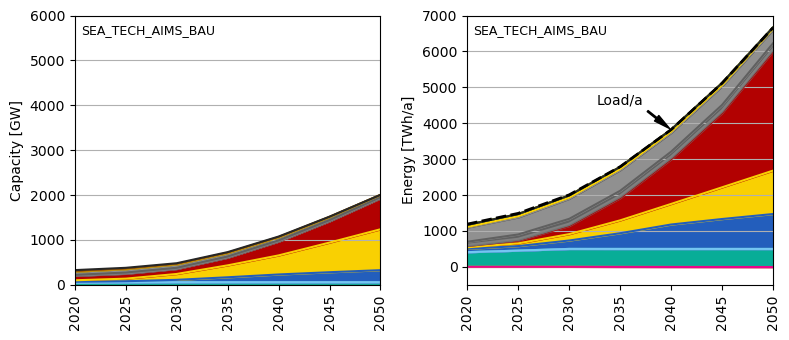

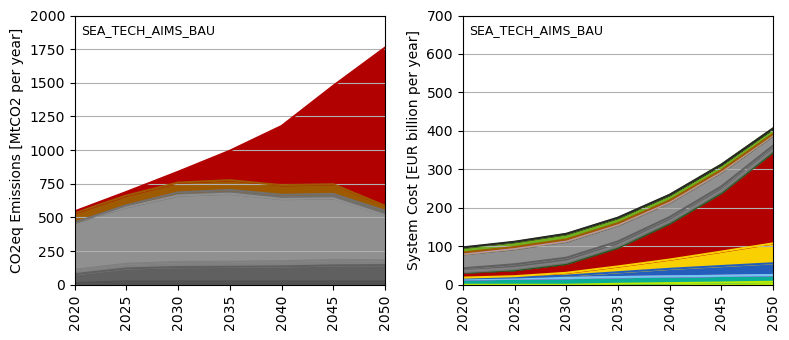

In [13]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth-final_V1"
dec_name = "BAU"

network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/energy.csv" for year in years}
scenario_infn_costs = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/costs.csv" for year in years}
fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years}

scenario_PyPSA = "SEA_TECH_AIMS_"

df = plot_capacity_energy(scenario_infn_cap, scenario_infn_energy, scenario_PyPSA, dec_name, config)

df3 = check_emission_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn, scenario_PyPSA, dec_name, config)

## Business As Usual Decarbonization Pathway:

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


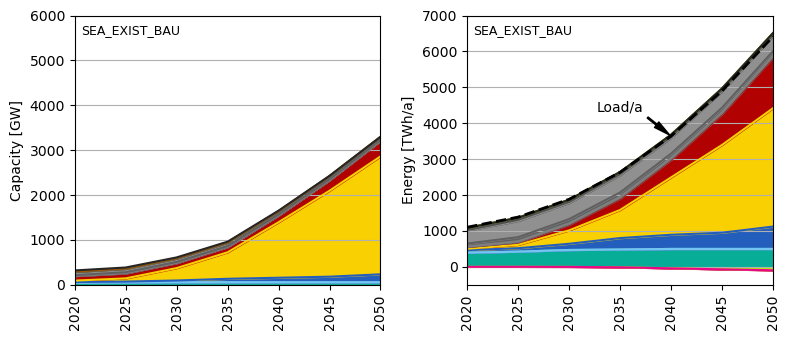

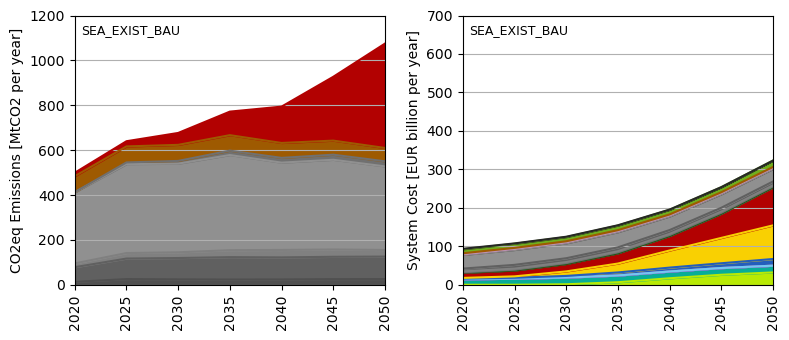

In [54]:
scenario_PyPSA = "SEA_EXIST_"
folder_name = "pypsa-earth"
dec_name = "BAU"

network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/energy.csv" for year in years}
scenario_infn_costs = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/costs.csv" for year in years}

df = plot_capacity_energy(scenario_infn_cap, scenario_infn_energy, scenario_PyPSA, dec_name, config)

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years}

df3 = check_emission_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn, scenario_PyPSA, dec_name, config)

In [64]:
df.loc[["solar PV","offshore wind dc","offshore wind ac","hydroelectricity","onshore wind"],2050].sum()/df.loc[:,2050].sum()

0.6886294040278657

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


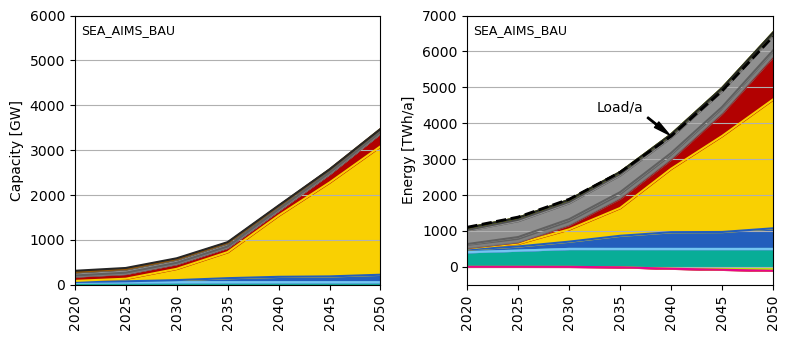

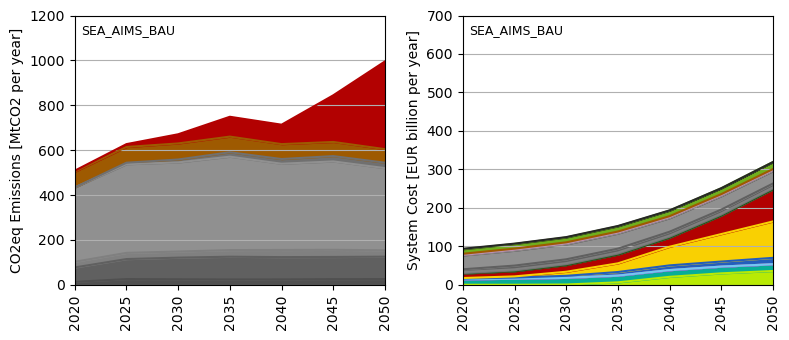

In [40]:
scenario_PyPSA = "SEA_AIMS_"
folder_name = "pypsa-earth"
dec_name = "BAU"

network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/energy.csv" for year in years}
scenario_infn_costs = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/costs.csv" for year in years}

df = plot_capacity_energy(scenario_infn_cap, scenario_infn_energy, scenario_PyPSA, dec_name, config)

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years}

df3 = check_emission_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn, scenario_PyPSA, dec_name, config)

In [29]:
df3[2050].sum()

319.1260772862206

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


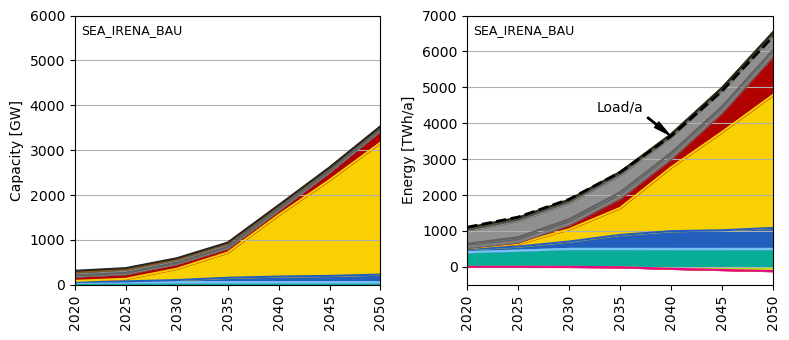

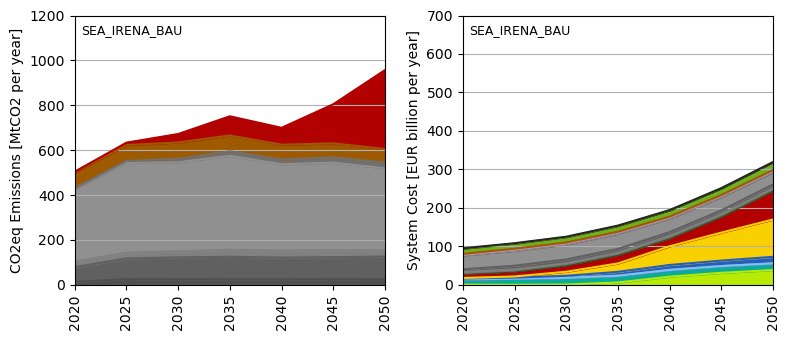

In [41]:
scenario_PyPSA = "SEA_IRENA_"
folder_name = "pypsa-earth"
dec_name = "BAU"

network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/energy.csv" for year in years}
scenario_infn_costs = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/costs.csv" for year in years}

df = plot_capacity_energy(scenario_infn_cap, scenario_infn_energy, scenario_PyPSA, dec_name, config)

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years}

df3 = check_emission_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn, scenario_PyPSA, dec_name, config)

In [31]:
df3[2050].sum()

318.9159072653831

## Stable Emission Decarbonization Pathway

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.916821-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.833641-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.750462-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.667283-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.584104-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators

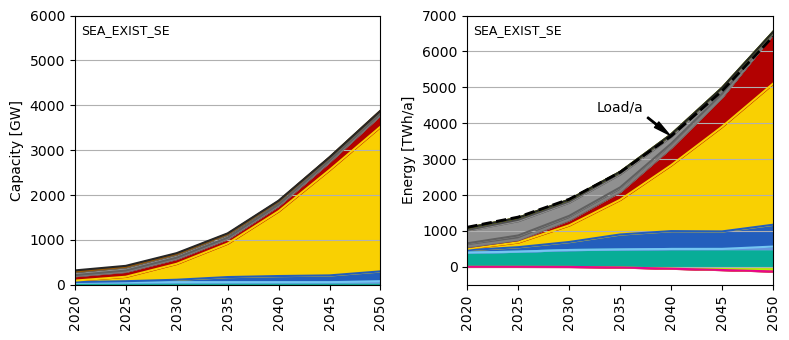

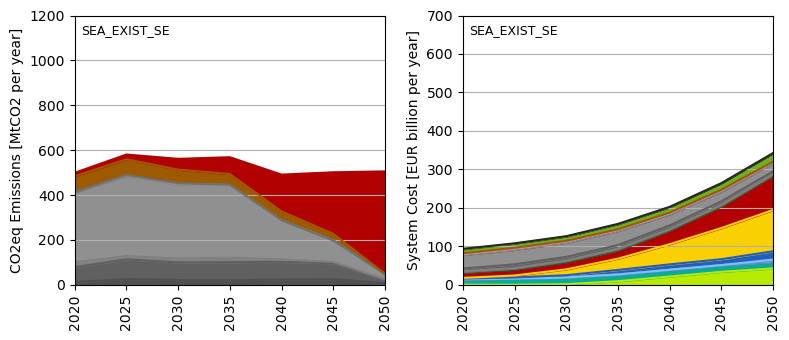

In [42]:
scenario_PyPSA = "SEA_EXIST_"
folder_name = "pypsa-earth"
dec_name = "SE"
SE_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.916821-3H",
             2030:"Co2L0.833641-3H",
             2035:"Co2L0.750462-3H",
             2040:"Co2L0.667283-3H",
             2045:"Co2L0.584104-3H",
             2050:"Co2L0.500924-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

co2_share = SE_co2_share

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}
scenario_infn_costs = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/costs.csv" for year in years}

df = plot_capacity_energy(scenario_infn_cap, scenario_infn_energy, scenario_PyPSA, dec_name, config)

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years}

df3 = check_emission_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn, scenario_PyPSA, dec_name, config)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.916821-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.833641-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.750462-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.667283-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.584104-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators

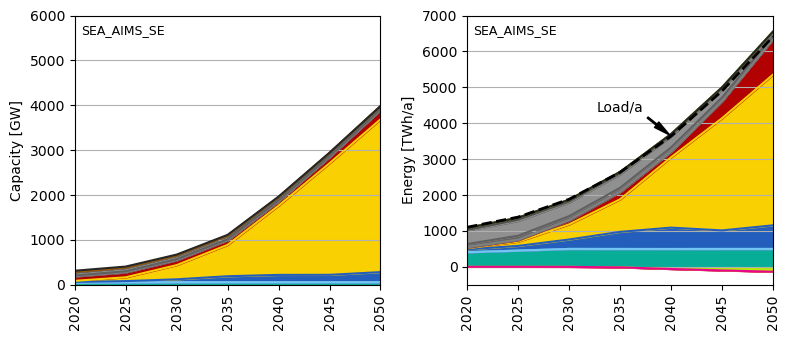

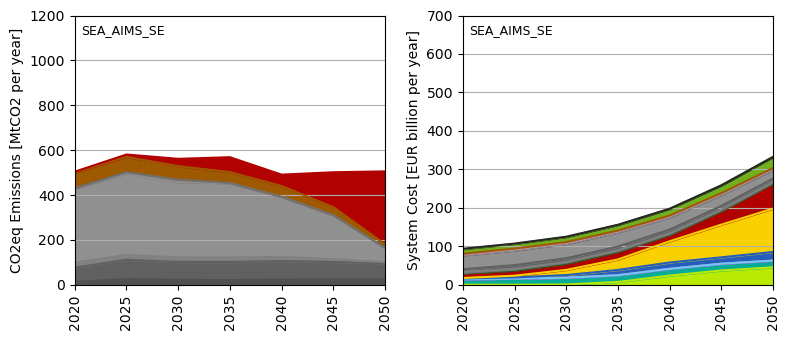

In [43]:
scenario_PyPSA = "SEA_AIMS_"
folder_name = "pypsa-earth"
dec_name = "SE"
SE_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.916821-3H",
             2030:"Co2L0.833641-3H",
             2035:"Co2L0.750462-3H",
             2040:"Co2L0.667283-3H",
             2045:"Co2L0.584104-3H",
             2050:"Co2L0.500924-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

co2_share = SE_co2_share

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}
scenario_infn_costs = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/costs.csv" for year in years}

df = plot_capacity_energy(scenario_infn_cap, scenario_infn_energy, scenario_PyPSA, dec_name, config)

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years}

df3 = check_emission_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn, scenario_PyPSA, dec_name, config)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.916821-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.833641-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.750462-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.667283-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.584104-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators

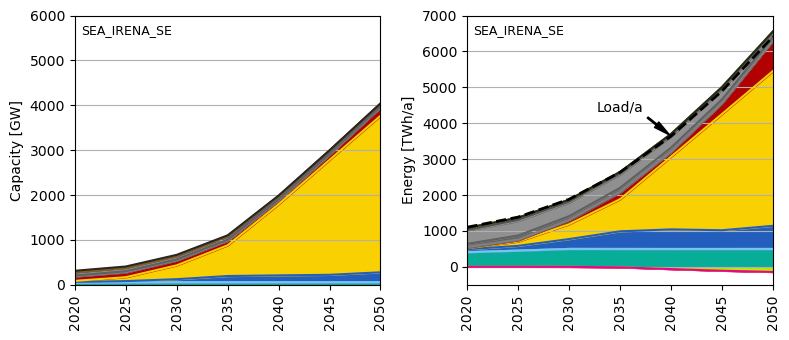

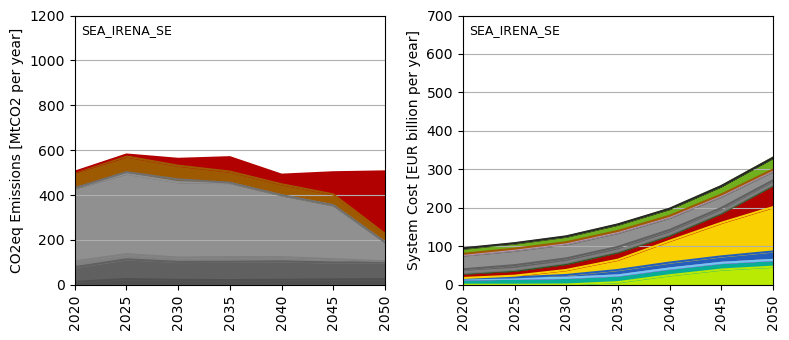

In [44]:
scenario_PyPSA = "SEA_IRENA_"
folder_name = "pypsa-earth"
dec_name = "SE"
SE_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.916821-3H",
             2030:"Co2L0.833641-3H",
             2035:"Co2L0.750462-3H",
             2040:"Co2L0.667283-3H",
             2045:"Co2L0.584104-3H",
             2050:"Co2L0.500924-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

co2_share = SE_co2_share

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}
scenario_infn_costs = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/costs.csv" for year in years}

df = plot_capacity_energy(scenario_infn_cap, scenario_infn_energy, scenario_PyPSA, dec_name, config)

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years}

df3 = check_emission_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn, scenario_PyPSA, dec_name, config)

# Decarbonize

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.779298-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.583549-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.412754-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.266913-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.146026-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators

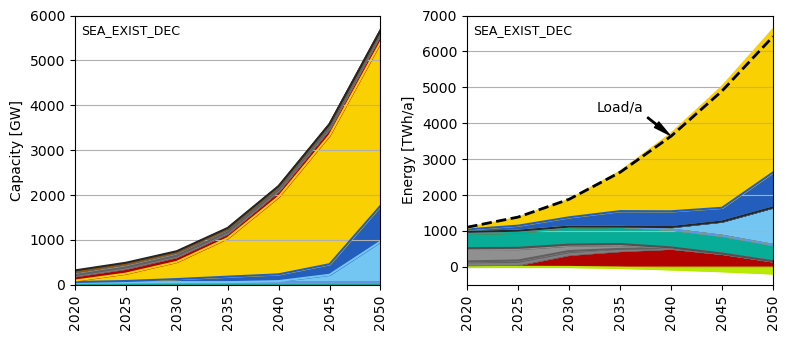

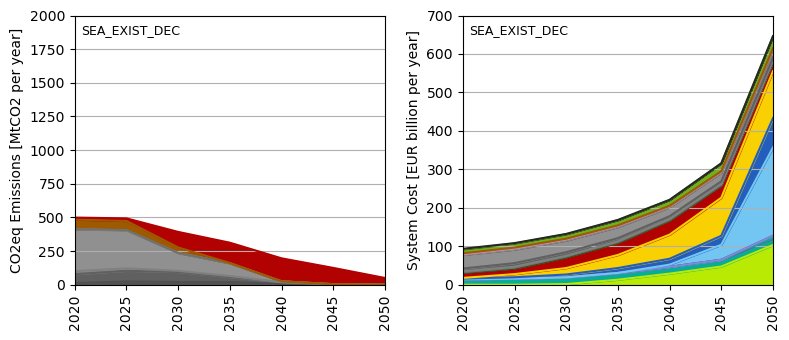

In [14]:
scenario_PyPSA = "SEA_EXIST_"
folder_name = "pypsa-earth"
dec_name = "DEC"
DEC_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.779298-3H",
             2030:"Co2L0.583549-3H",
             2035:"Co2L0.412754-3H",
             2040:"Co2L0.266913-3H",
             2045:"Co2L0.146026-3H",
             2050:"Co2L0.050092-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

co2_share = DEC_co2_share

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}
scenario_infn_costs = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/costs.csv" for year in years}

df = plot_capacity_energy(scenario_infn_cap, scenario_infn_energy, scenario_PyPSA, dec_name, config)

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years}

df3 = check_emission_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn, scenario_PyPSA, dec_name, config)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.779298-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.583549-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.412754-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.266913-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.146026-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators

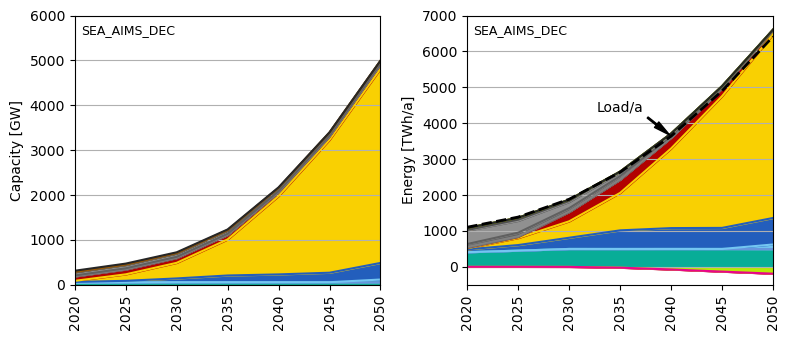

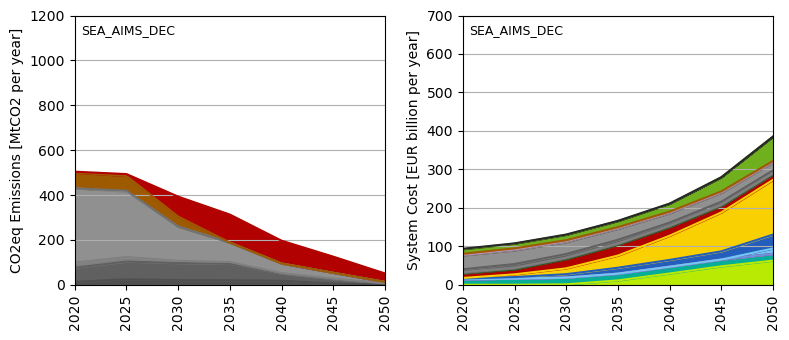

In [46]:
scenario_PyPSA = "SEA_AIMS_"
folder_name = "pypsa-earth"
dec_name = "DEC"
DEC_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.779298-3H",
             2030:"Co2L0.583549-3H",
             2035:"Co2L0.412754-3H",
             2040:"Co2L0.266913-3H",
             2045:"Co2L0.146026-3H",
             2050:"Co2L0.050092-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

co2_share = DEC_co2_share

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}
scenario_infn_costs = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/costs.csv" for year in years}

df = plot_capacity_energy(scenario_infn_cap, scenario_infn_energy, scenario_PyPSA, dec_name, config)

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years}

df3 = check_emission_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn, scenario_PyPSA, dec_name, config)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.779298-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.583549-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.412754-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.266913-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.146026-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators

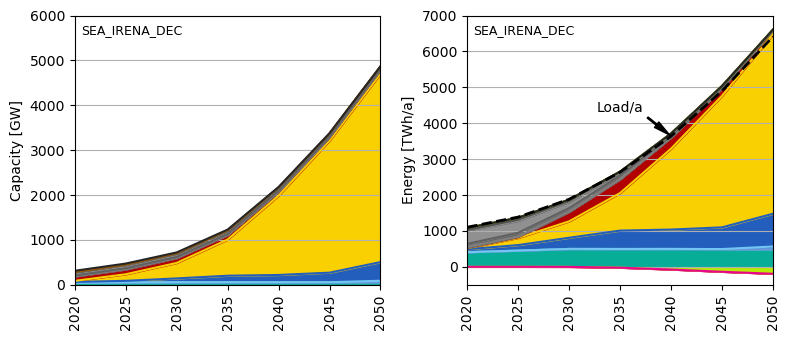

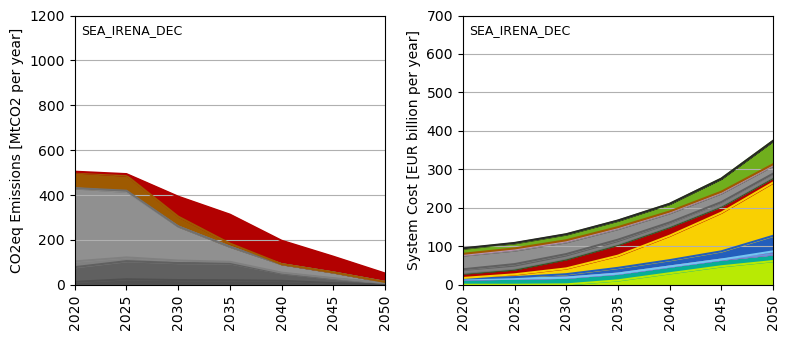

In [47]:
scenario_PyPSA = "SEA_IRENA_"
folder_name = "pypsa-earth"
dec_name = "DEC"
DEC_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.779298-3H",
             2030:"Co2L0.583549-3H",
             2035:"Co2L0.412754-3H",
             2040:"Co2L0.266913-3H",
             2045:"Co2L0.146026-3H",
             2050:"Co2L0.050092-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

co2_share = DEC_co2_share

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}
scenario_infn_costs = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/costs.csv" for year in years}

df = plot_capacity_energy(scenario_infn_cap, scenario_infn_energy, scenario_PyPSA, dec_name, config)

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years}

df3 = check_emission_system_cost(scenario_infn_cap, scenario_infn_energy, scenario_infn_costs, fn, scenario_PyPSA, dec_name, config)

# Unused

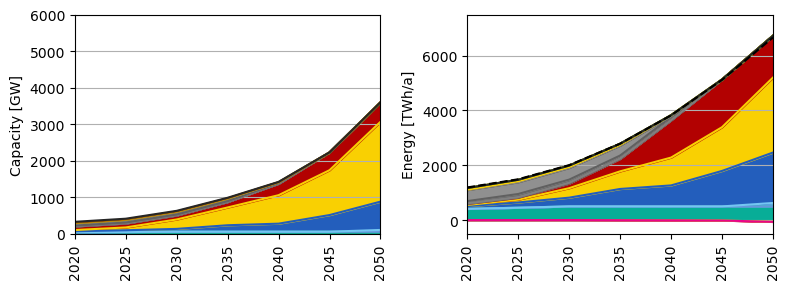

In [14]:
scenario_PyPSA = {2020: "SEA_opt_stable_BAU_",
                  2025: "SEA_opt_stable_BAU_",
                  2030: "SEA_opt_stable_BAU_",
                  2035: "SEA_opt_stable_BAU_",
                  2040: "SEA_opt_stable_BAU_",
                  2045: "SEA_opt_BAU_",
                  2050: "SEA_opt_BAU_"}

folder_name = "pypsa-earth"
co2_share = {2020:"Co2L1.0-3H",
             2025:"Co2L0.882919-3H",
             2030:"Co2L0.765839-3H",
             2035:"Co2L0.648758-3H",
             2040:"Co2L0.531677-3H",
             2045:"Co2L0.414596-3H",
             2050:"Co2L0.297516-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA[year] + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA[year] + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}

plot_capacity_energy(scenario_infn_cap, scenario_infn_energy,f"SEA_opt_stable_BAU_{network_name}", config)

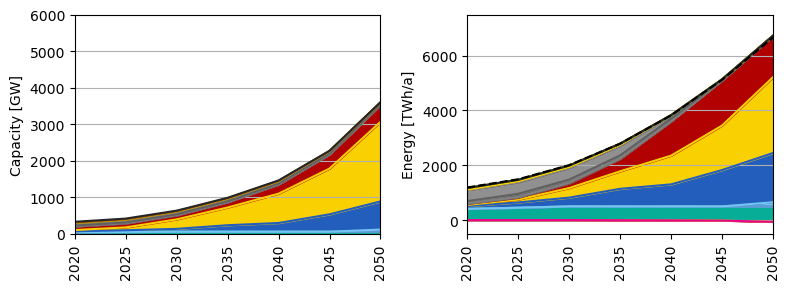

In [16]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth"
co2_share = {2020:"Co2L1.0-3H",
             2025:"Co2L0.882919-3H",
             2030:"Co2L0.765839-3H",
             2035:"Co2L0.648758-3H",
             2040:"Co2L0.531677-3H",
             2045:"Co2L0.414596-3H",
             2050:"Co2L0.297516-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}

plot_capacity_energy(scenario_infn_cap, scenario_infn_energy,f"{scenario_PyPSA}{network_name}", config)

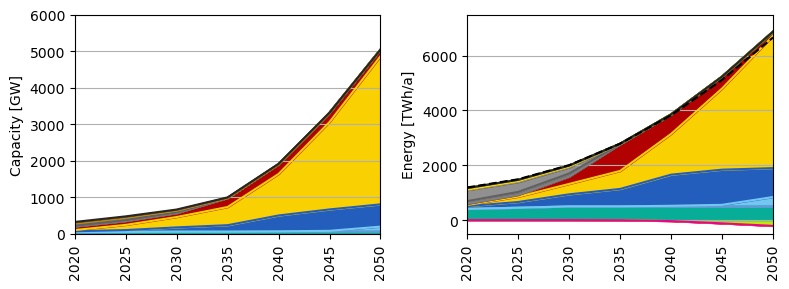

In [13]:
scenario_PyPSA = {2020: "SEA_opt_dec_BAU_",
                  2025: "SEA_opt_dec_BAU_",
                  2030: "SEA_opt_dec_BAU_",
                  2035: "SEA_opt_dec_BAU_",
                  2040: "SEA_opt_dec_BAU_",
                  2045: "SEA_opt_BAU_",
                  2050: "SEA_opt_BAU_"}

folder_name = "pypsa-earth"
co2_share = {2020:"Co2L1.0-3H",
             2025:"Co2L0.750481-3H",
             2030:"Co2L0.536087-3H",
             2035:"Co2L0.356817-3H",
             2040:"Co2L0.212671-3H",
             2045:"Co2L0.103649-3H",
             2050:"Co2L0.029752-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

scenario_infn_cap = {year:f"../{folder_name}/results/{scenario_PyPSA[year] + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/capacity.csv" for year in years}
scenario_infn_energy = {year:f"../{folder_name}/results/{scenario_PyPSA[year] + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/energy.csv" for year in years}

plot_capacity_energy(scenario_infn_cap, scenario_infn_energy,f"SEA_opt_dec_BAU_{network_name}", config)

# Triple Combined Plots

In [10]:
def plot_energy_3(scenario_infn, scenario_PyPSA, config):

    years = [2020,2025,2030,2035,2040,2045,2050]

    fig_energy, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 4.7))
    axis_order = -1
    axis_name = [ax1, ax2, ax3]
    
    for scenario_name, scenario in scenario_infn.items():
        
        axis_order += 1
        df_all = pd.DataFrame()
        loads_df_all = pd.DataFrame()

        for year, infn in scenario.items():
    
            energy_df = pd.read_csv(infn, index_col=list(range(2)), header=[1, 2, 3])
    
            energy_df.columns = [year]
        
            df = energy_df.groupby(energy_df.index.get_level_values(1)).sum()
    
            loads_df = - energy_df.groupby(energy_df.index.get_level_values(0)).sum().query("index == 'loads'")/ 1e6
    
            # If there is any unique carrier to remove
            if "B2B" in df.index:
                df = df.drop("B2B")
        
            # convert MWh to TWh
            df = df / 1e6
        
            df = df.groupby(df.index.map(rename_techs)).sum()
            
            if df_all.empty:
                df_all = df
            else:
                df_all = pd.concat([df_all,df],axis=1)
    
            if loads_df.empty:
                loads_df_all = loads_df
            else:
                loads_df_all = pd.concat([loads_df_all,loads_df],axis=1)
        
        new_index_energy = df_all.index.intersection(preferred_order).append(
            df.index.difference(preferred_order)
        )
    
        new_columns = df_all.columns.sort_values()
        
        #fig_energy.set_size_inches((8, 6))
    
        if new_index_energy.empty:
            print(f"No energy data to plot for country, no valid plot is generated")
            # create empty file to avoid issues with snakemake
            with open(infn[year], "w") as fp:
                pass
            return

        ax = axis_name[axis_order]

        df_all.loc[new_index_energy, new_columns].T.plot(
            kind="area",
            ax=ax,
            stacked=True,
            color=[config["plotting"]["tech_colors"][i] for i in new_index_energy],
            rot=90
        )
    
        loads_df_all.loc[:, new_columns].T.plot(
            kind="line",
            ax=ax,
            color="black",
            linestyle = 'dashed',
            rot=90
        )

        ax.grid(axis="y")
        ax.set_ylim([-500, 8000])
        ax.set_xlim([2020,2050])

        if ax == ax1:
            ax.set_ylabel("Energy [TWh/a]")

        if ax == ax3:
            handles, labels = ax.get_legend_handles_labels()
            handles.reverse()
            labels.reverse()
            ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.5))
        else:
            ax.get_legend().remove()

    fig_energy.tight_layout()

    if not os.path.exists(f'output_gif/{scenario_PyPSA}'):
        os.mkdir(f'output_gif/{scenario_PyPSA}')

    plt.savefig(f'output_gif/{scenario_PyPSA}/{scenario_PyPSA}_energy_generation.png',bbox_inches='tight')


In [11]:
def plot_costs_3(scenario_infn, scenario_PyPSA, config):

    years = [2020,2025,2030,2035,2040,2045,2050]

    fig_costs, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 4.7))
    axis_order = -1
    axis_name = [ax1, ax2, ax3]
    
    for scenario_name, scenario in scenario_infn.items():
        
        axis_order += 1
        df_all = pd.DataFrame()
        loads_df_all = pd.DataFrame()

        for year, infn in scenario.items():
            # For now ignore the simpl header
            cost_df = pd.read_csv(infn, index_col=list(range(3)), header=[1, 2, 3])
    
            #cost_df.columns = [str(infn[fn])]
        
            df = cost_df.groupby(cost_df.index.get_level_values(2)).sum()
    
            # If there is any unique carrier to remove
            if "B2B" in df.index:
                df = df.drop("B2B")
    
            # convert to billions
            df = df / 1e9
        
            df = df.groupby(df.index.map(rename_techs)).sum()
    
            df.columns = [year]
            
            if df_all.empty:
                df_all = df
            else:
                df_all = pd.concat([df_all,df],axis=1)
    
        new_index_costs = df_all.index.intersection(preferred_order).append(
            df.index.difference(preferred_order)
        )
    
        new_columns = df_all.columns.sort_values()

        ax = axis_name[axis_order]

        df_all.loc[new_index_costs, new_columns].T.plot(
            kind="area",
            ax=ax,
            stacked=True,
            color=[config["plotting"]["tech_colors"][i] for i in new_index_costs],
            rot=90
        )

        ax.grid(axis="y")
        ax.set_ylim([0, 1000])
        ax.set_xlim([2020,2050])

        if ax == ax1:
            ax.set_ylabel("System Cost [EUR billion per year]")

        if ax == ax3:
            handles, labels = ax.get_legend_handles_labels()
            handles.reverse()
            labels.reverse()
            ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.5))
        else:
            ax.get_legend().remove()

    fig_costs.tight_layout()

    if not os.path.exists(f'output_gif/{scenario_PyPSA}'):
        os.mkdir(f'output_gif/{scenario_PyPSA}')

    plt.savefig(f'output_gif/{scenario_PyPSA}/{scenario_PyPSA}_system_cost.png',bbox_inches='tight')

In [12]:
def plot_capacity_3(scenario_infn, scenario_PyPSA, config):

    years = [2020,2025,2030,2035,2040,2045,2050]

    fig_cap, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12, 4.7))
    axis_order = -1
    axis_name = [ax1, ax2, ax3]
    
    for scenario_name, scenario in scenario_infn.items():
        
        axis_order += 1
        df_all = pd.DataFrame()
        loads_df_all = pd.DataFrame()

        for year, infn in scenario.items():
            # For now ignore the simpl header
            cap_df = pd.read_csv(infn, index_col=list(range(2)), header=[1, 2, 3])

            cap_df["component"] = cap_df.index.get_level_values(0)

            cap_df = cap_df[cap_df.component == "generators"]

            cap_df = cap_df.drop(columns=["component"])
        
            df = cap_df.groupby(cap_df.index.get_level_values(1)).sum()
    
            # If there is any unique carrier to remove
            if "B2B" in df.index:
                df = df.drop("B2B")
    
            # convert from MW to GW
            df = df / 1e3
        
            df = df.groupby(df.index.map(rename_techs)).sum()
    
            df.columns = [year]
            
            if df_all.empty:
                df_all = df
            else:
                df_all = pd.concat([df_all,df],axis=1)
    
        new_index_cap = df_all.index.intersection(preferred_order).append(
            df.index.difference(preferred_order)
        )
    
        new_columns = df_all.columns.sort_values()

        ax = axis_name[axis_order]

        df_all.loc[new_index_cap, new_columns].T.plot(
            kind="area",
            ax=ax,
            stacked=True,
            color=[config["plotting"]["tech_colors"][i] for i in new_index_cap],
            rot=90
        )

        ax.grid(axis="y")
        ax.set_ylim([0, 6000])
        ax.set_xlim([2020,2050])

        if ax == ax1:
            ax.set_ylabel("Capacity [GW]")

        if ax == ax3:
            handles, labels = ax.get_legend_handles_labels()
            handles.reverse()
            labels.reverse()
            ax.legend(handles, labels, ncol=1, loc="center left", bbox_to_anchor=(1, 0.5))
        else:
            ax.get_legend().remove()

    fig_cap.tight_layout()

    #if not os.path.exists(f'output_gif/{scenario_PyPSA}'):
    #    os.mkdir(f'output_gif/{scenario_PyPSA}')

    #plt.savefig(f'output_gif/{scenario_PyPSA}/{scenario_PyPSA}_system_cost.png',bbox_inches='tight')

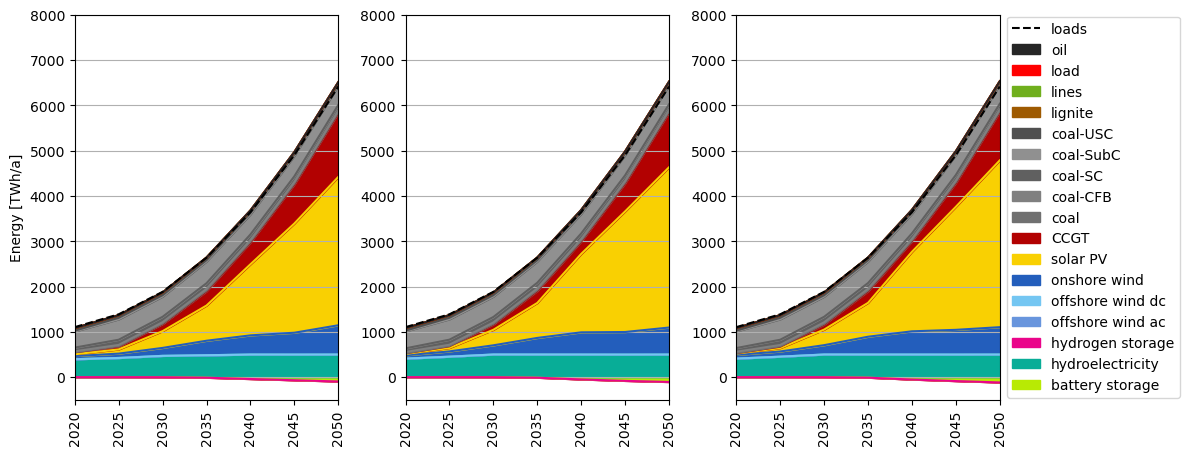

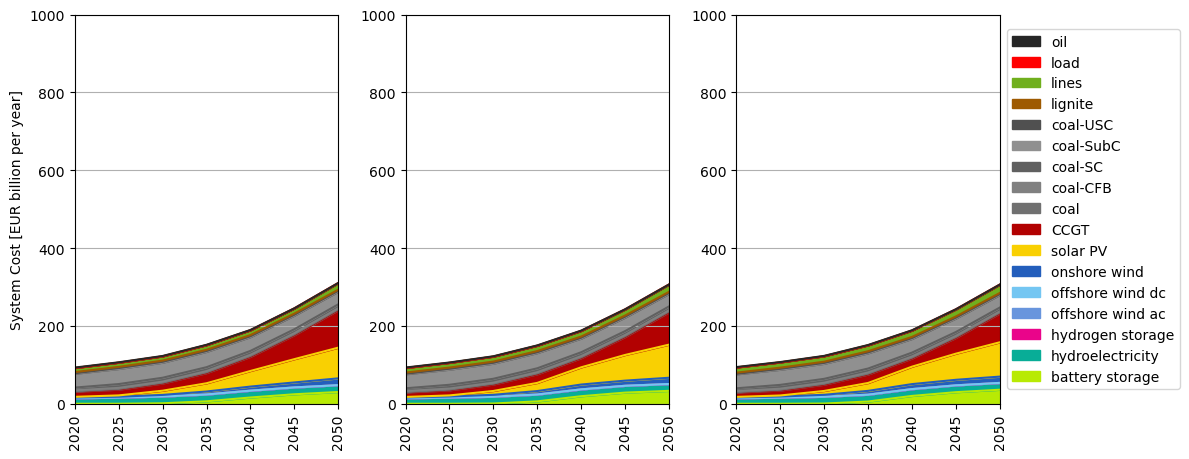

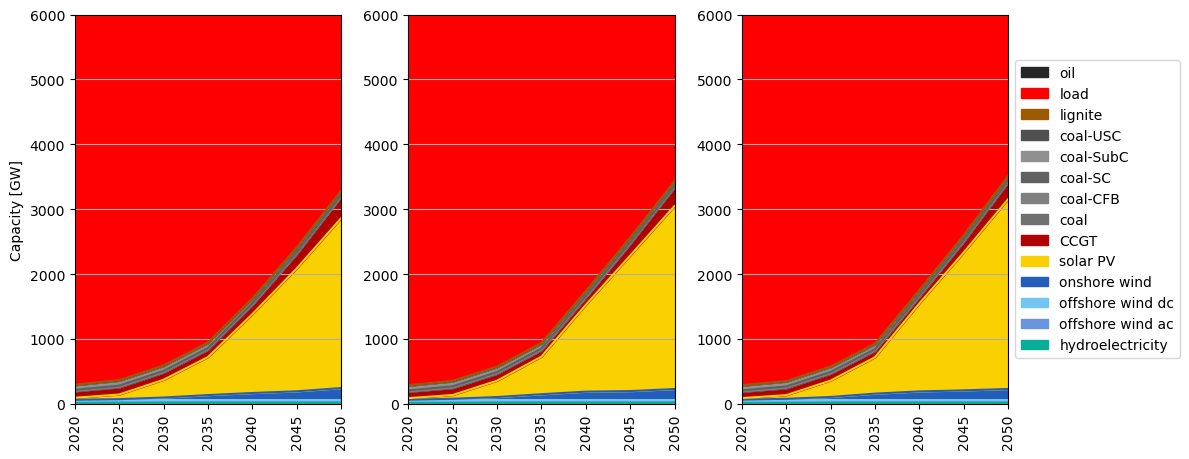

In [13]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"

network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_energy_3(scenario_infn,"PyPSA-SEA_No_limits", config)

compare = "costs"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_costs_3(scenario_infn,"PyPSA-SEA_No_limits", config)

compare = "capacity"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_capacity_3(scenario_infn,"PyPSA-SEA_No_limits", config)

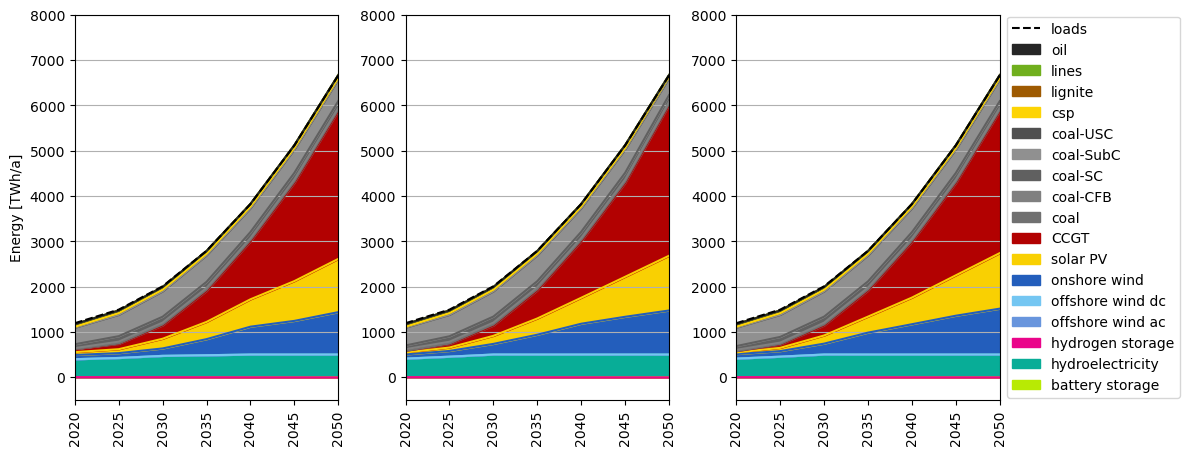

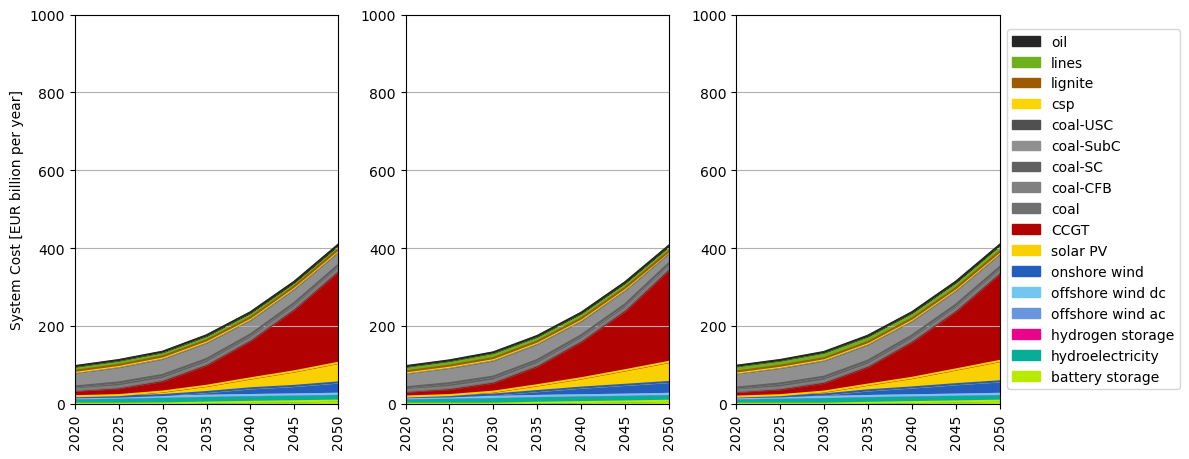

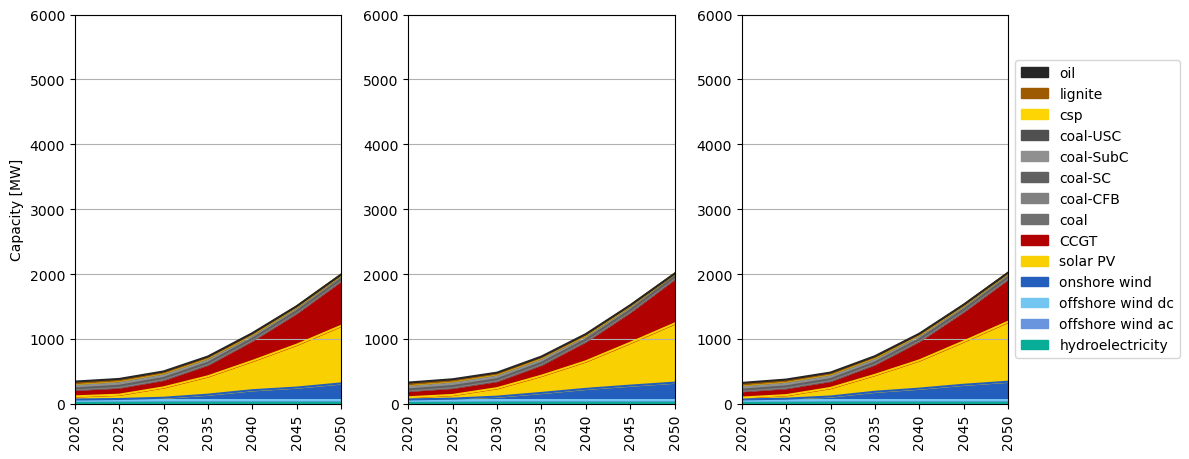

In [76]:
scenarios = ["SEA_INT_", "SEA_BAU_", "SEA_EXT_"]
folder_name = "pypsa-earth"

network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_energy_3(scenario_infn,"PyPSA-SEA_No_limits", config)

compare = "costs"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_costs_3(scenario_infn,"PyPSA-SEA_No_limits", config)

compare = "capacity"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_capacity_3(scenario_infn,"PyPSA-SEA_No_limits", config)

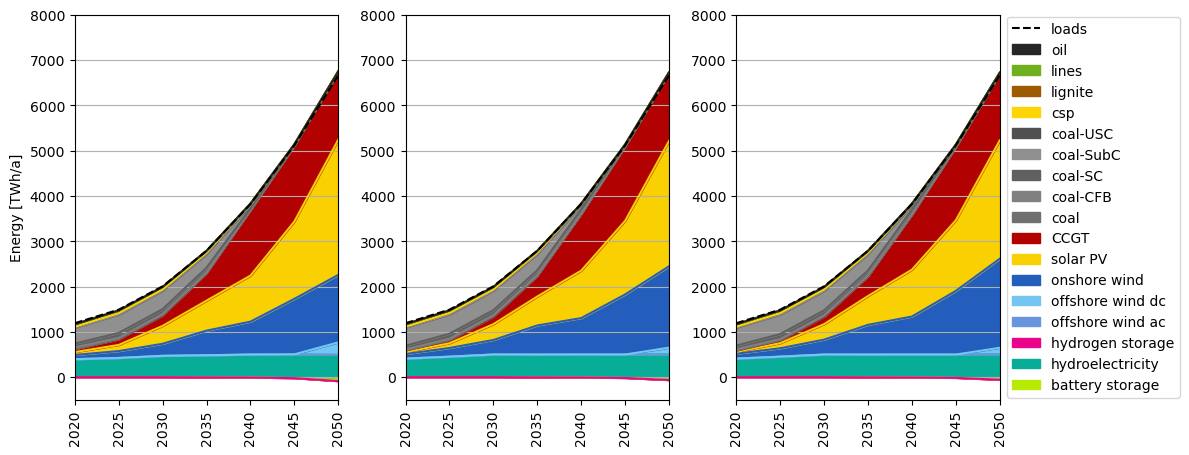

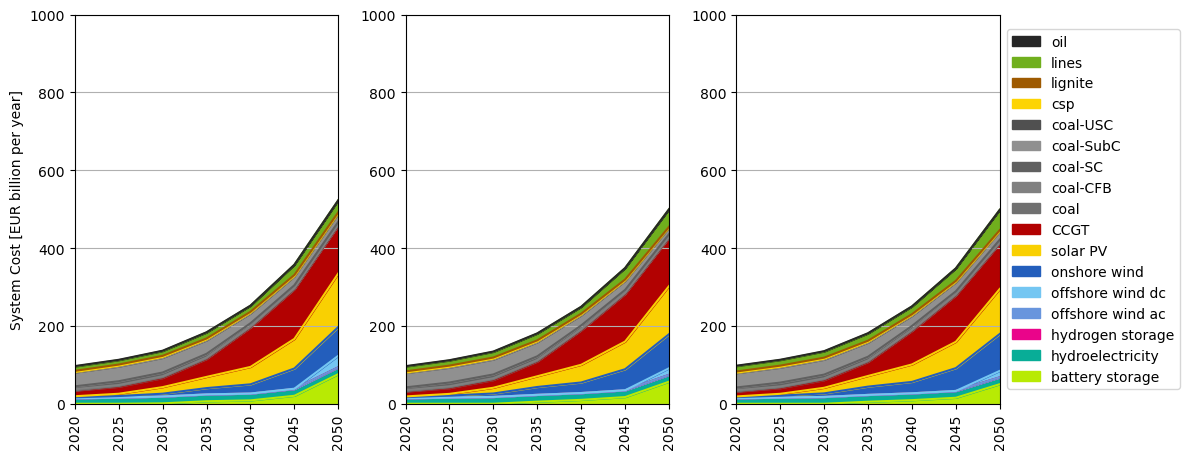

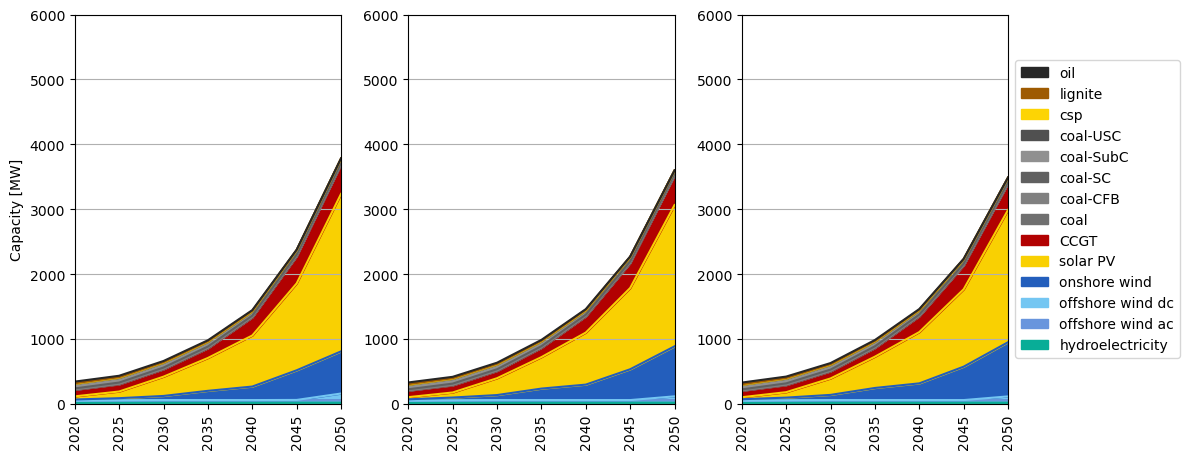

In [77]:
scenarios = ["SEA_INT_", "SEA_BAU_", "SEA_EXT_"]
folder_name = "pypsa-earth"
co2_share = {2020:"Co2L1.0-3H",
             2025:"Co2L0.882919-3H",
             2030:"Co2L0.765839-3H",
             2035:"Co2L0.648758-3H",
             2040:"Co2L0.531677-3H",
             2045:"Co2L0.414596-3H",
             2050:"Co2L0.297516-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_energy_3(scenario_infn,"PyPSA-SEA_Stable", config)

compare = "costs"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_costs_3(scenario_infn,"PyPSA-SEA_Stable", config)

compare = "capacity"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_capacity_3(scenario_infn,"PyPSA-SEA_Stable", config)

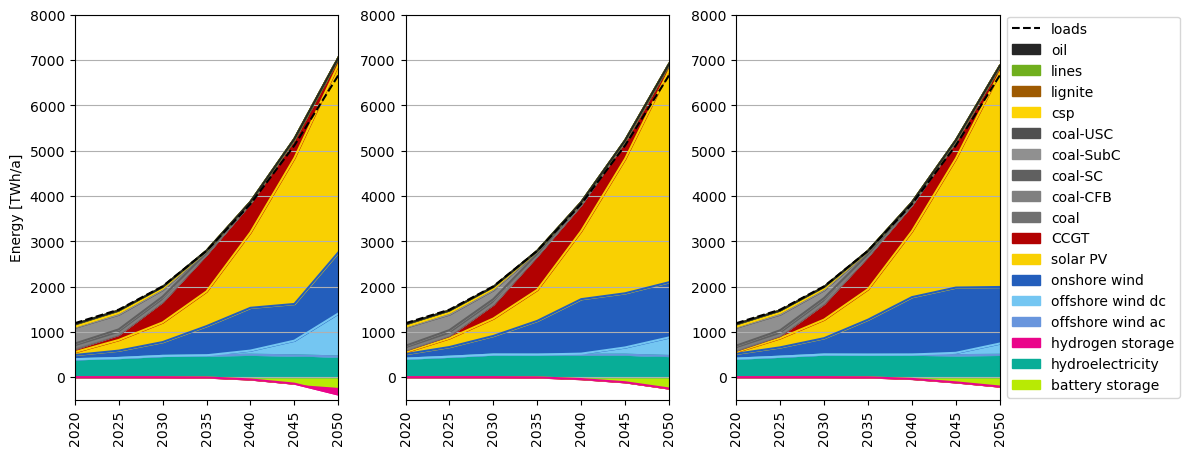

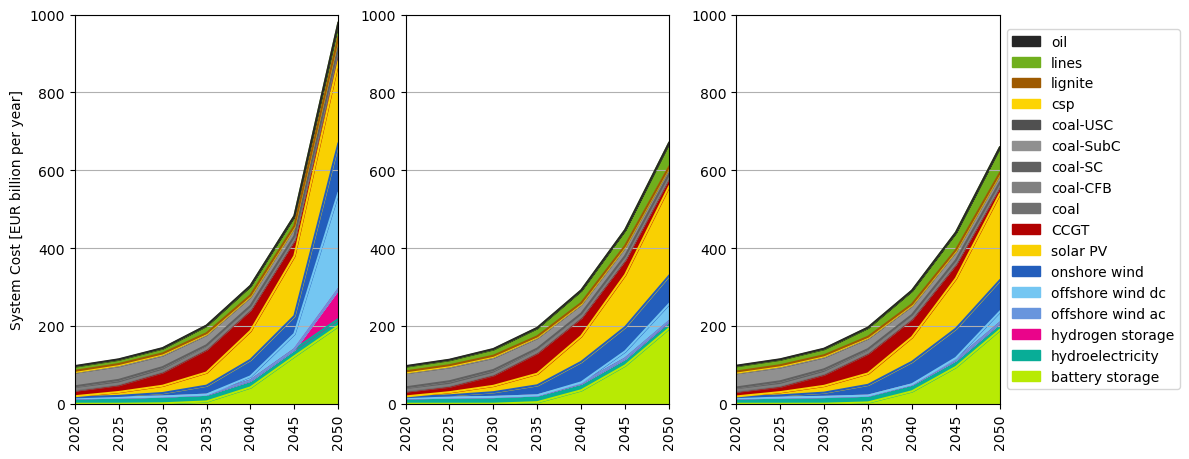

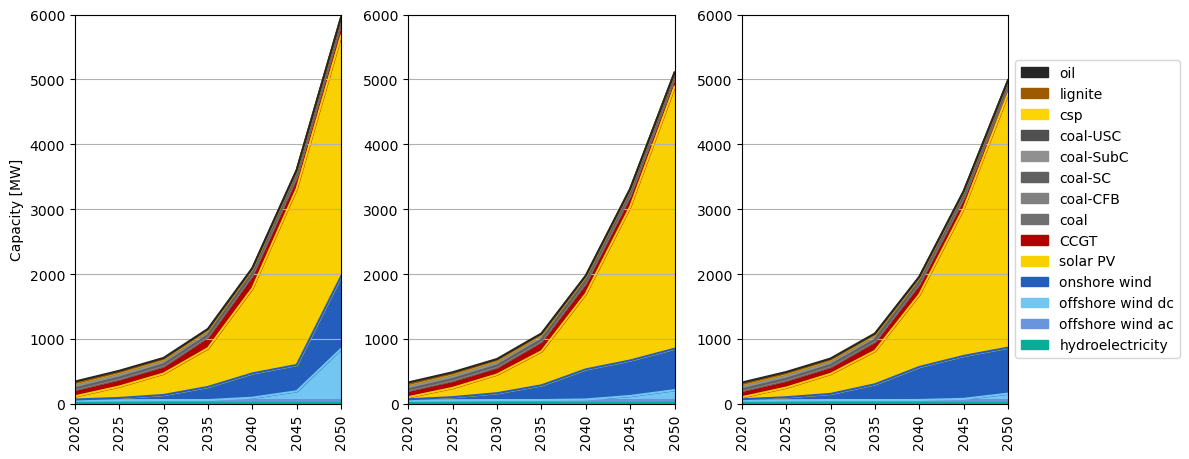

In [78]:
scenarios = ["SEA_INT_", "SEA_BAU_", "SEA_EXT_"]
folder_name = "pypsa-earth"
co2_share = {2020:"Co2L1.0-3H",
             2025:"Co2L0.750481-3H",
             2030:"Co2L0.536087-3H",
             2035:"Co2L0.356817-3H",
             2040:"Co2L0.212671-3H",
             2045:"Co2L0.103649-3H",
             2050:"Co2L0.029752-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_energy_3(scenario_infn,"PyPSA-SEA_Dec", config)

compare = "costs"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_costs_3(scenario_infn,"PyPSA-SEA_Dec", config)

compare = "capacity"

scenario_infn = {scenario_PyPSA:{year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}{co2_share[year]}_{country}/{compare}.csv" for year in years} for scenario_PyPSA in scenarios}

plot_capacity_3(scenario_infn,"PyPSA-SEA_No_limits", config)

# No limits

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


renewable share in 2050 is 40.21527629773476%
system cost in 2050 is 406.4184255584543%


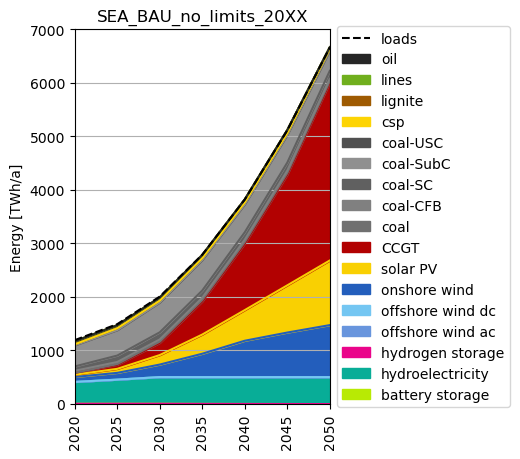

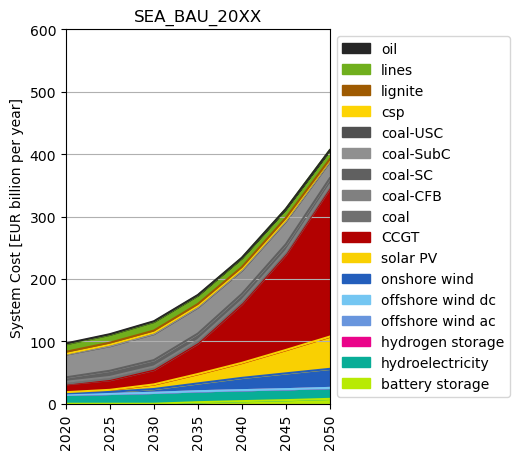

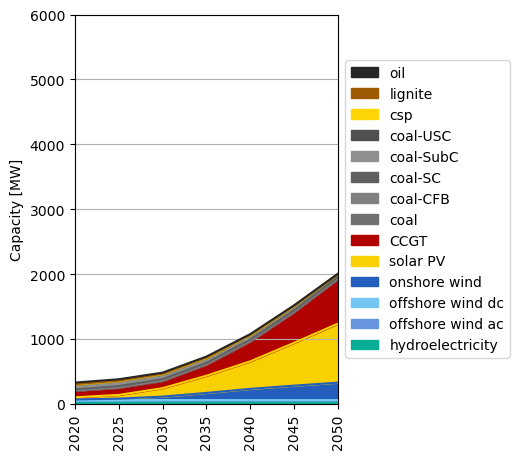

In [113]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth"

network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years} 

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"

infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}

df_plot = plot_energy(infn,f"{scenario_PyPSA}no_limits_", config)
renewable_energy = df_plot.loc[["hydroelectricity","solar PV","onshore wind","offshore wind ac","offshore wind dc"],2050].sum()
renewable_share = (renewable_energy/df_plot.loc[:,2050].sum())*100
print(f"renewable share in 2050 is {renewable_share}%")

compare = "costs"
infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}

df_cost = plot_costs(infn,f"{scenario_PyPSA}no_limits_", config)
system_cost = df_cost.loc[:,2050].sum()
print(f"system cost in 2050 is {system_cost}%")

compare = "capacity"
infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}

plot_capacity(infn,f"{scenario_PyPSA}no_limits_", config)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


renewable share in 2050 is 39.16860228556679%
system cost in 2050 is 408.8031754790883%


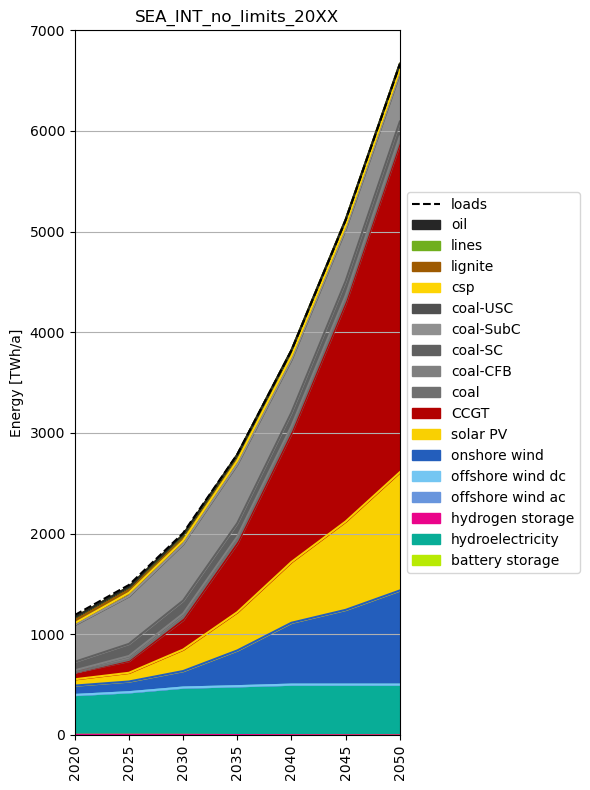

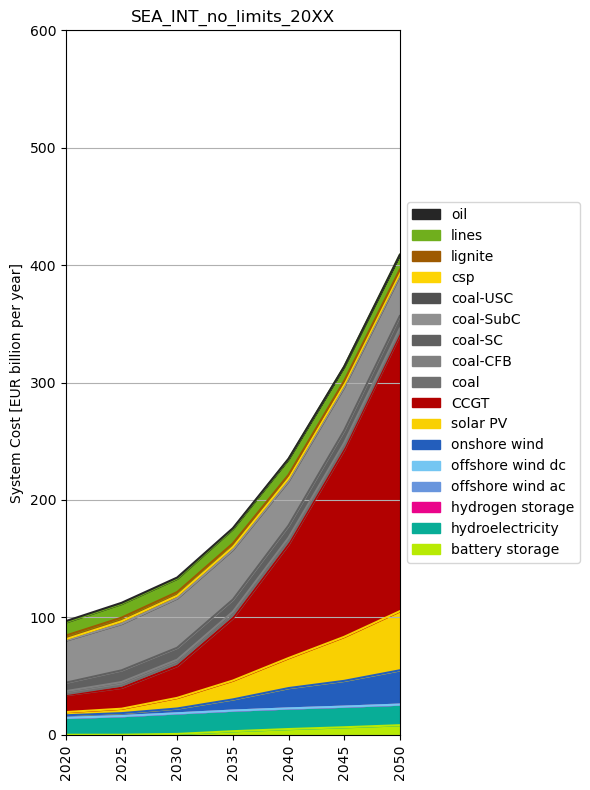

In [7]:
scenario_PyPSA = "SEA_INT_"
folder_name = "pypsa-earth"

network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years} 

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"

infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}

df_plot = plot_energy(infn,f"{scenario_PyPSA}no_limits_", config)
renewable_energy = df_plot.loc[["hydroelectricity","solar PV","onshore wind","offshore wind ac","offshore wind dc"],2050].sum()
renewable_share = (renewable_energy/df_plot.loc[:,2050].sum())*100
print(f"renewable share in 2050 is {renewable_share}%")

compare = "costs"
infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}

df_cost = plot_costs(infn,f"{scenario_PyPSA}no_limits_", config)
system_cost = df_cost.loc[:,2050].sum()
print(f"system cost in 2050 is {system_cost}%")

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


renewable share in 2050 is 41.09771193861208%
system cost in 2050 is 408.3703908667876%


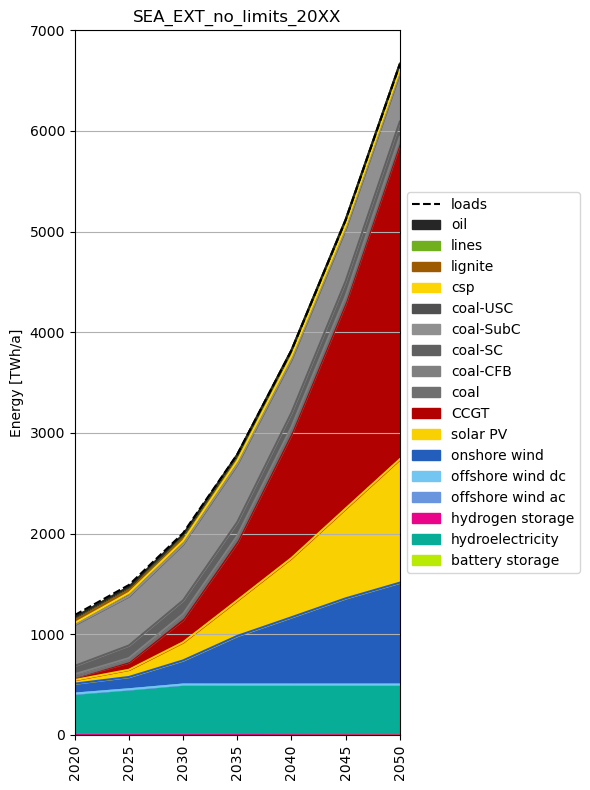

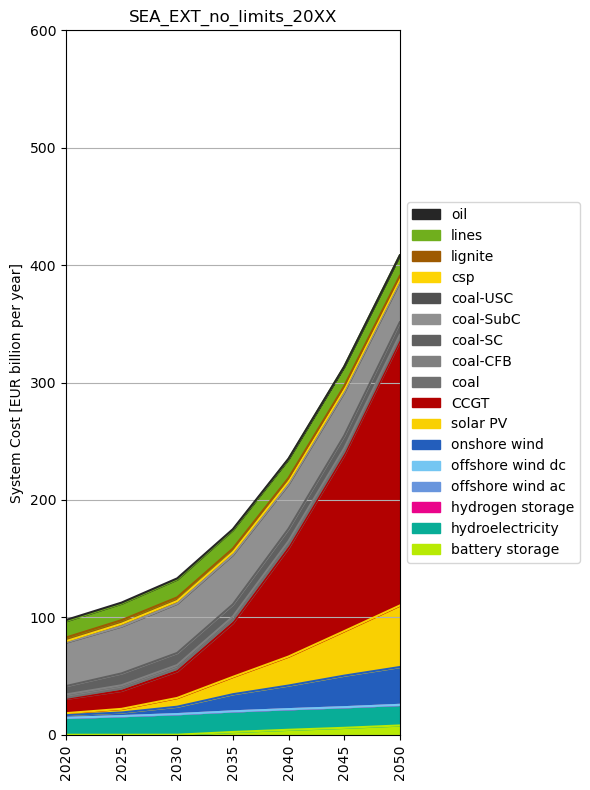

In [8]:
scenario_PyPSA = "SEA_EXT_"
folder_name = "pypsa-earth"

network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years} 

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"

infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}

df_plot = plot_energy(infn,f"{scenario_PyPSA}no_limits_", config)
renewable_energy = df_plot.loc[["hydroelectricity","solar PV","onshore wind","offshore wind ac","offshore wind dc"],2050].sum()
renewable_share = (renewable_energy/df_plot.loc[:,2050].sum())*100
print(f"renewable share in 2050 is {renewable_share}%")

compare = "costs"
infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}

df_cost = plot_costs(infn,f"{scenario_PyPSA}no_limits_", config)
system_cost = df_cost.loc[:,2050].sum()
print(f"system cost in 2050 is {system_cost}%")

In [10]:
# Stable

In [ ]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth"
co2_share = {2020:"Co2L1.0-3H",
             2025:"Co2L0.882919-3H",
             2030:"Co2L0.765839-3H",
             2035:"Co2L0.648758-3H",
             2040:"Co2L0.531677-3H",
             2045:"Co2L0.414596-3H",
             2050:"Co2L0.297516-3H"
            }
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years} 

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"

infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}

df_plot = plot_energy(infn,f"{scenario_PyPSA}stable_", config)
renewable_energy = df_plot.loc[["hydroelectricity","solar PV","onshore wind","offshore wind ac","offshore wind dc"],2050].sum()
renewable_share = (renewable_energy/df_plot.loc[:,2050].sum())*100
print(f"renewable share in 2050 is {renewable_share}%")

compare = "costs"
infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}

df_cost = plot_costs(infn,f"{scenario_PyPSA}stable_", config)
system_cost = df_cost.loc[:,2050].sum()
print(f"system cost in 2050 is {system_cost}%")

# Test market based optimization

In [18]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_3H"

years = [2025,2030,2035,2040]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"
infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}
infn[2020] = f"../{folder_name}/results/SEA_BAU_B_2020/summaries/{network_name}_{country}/{compare}.csv"

plot_energy(infn, scenario_PyPSA, config)

compare = "costs"
infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}
infn[2020] = f"../{folder_name}/results/SEA_BAU_B_2020/summaries/{network_name}_{country}/{compare}.csv"

plot_costs(infn, scenario_PyPSA, config)

FileNotFoundError: [Errno 2] No such file or directory: '../pypsa-earth/results/SEA_BAU_B_2020/summaries/elec_s_200_ec_lcopt_3H_all/energy.csv'

# Test BAU with gas Model

renewable share in 2050 is 94.43721553482564%
system cost in 2050 is 556.8132398632174%


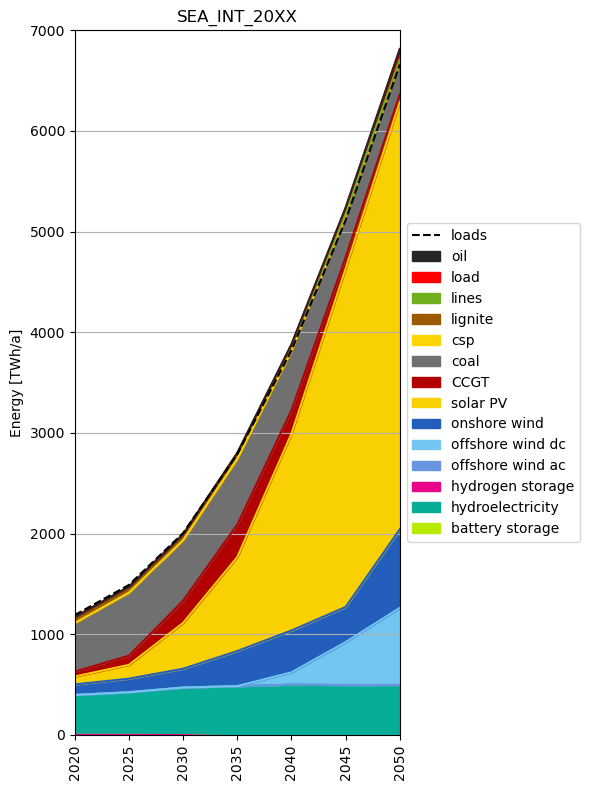

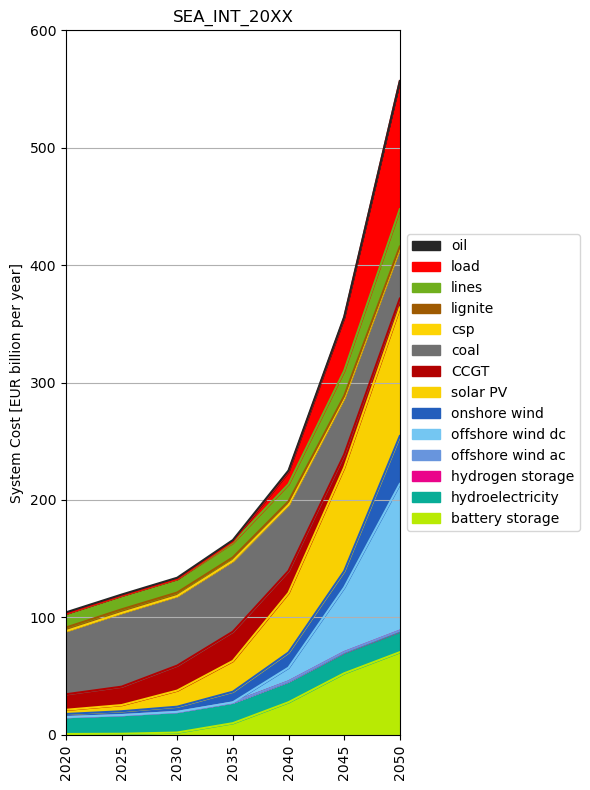

In [11]:
scenario_PyPSA = "SEA_INT_"
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"
infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}

df_plot = plot_energy(infn, scenario_PyPSA, config)
renewable_energy = df_plot.loc[["hydroelectricity","solar PV","onshore wind","offshore wind ac","offshore wind dc"],2050].sum()
renewable_share = (renewable_energy/df_plot.loc[:,2050].sum())*100
print(f"renewable share in 2050 is {renewable_share}%")

#backup_energy = df_plot.loc[["biogas"],2050].sum()
#backup_share = (backup_energy/df_plot.loc[:,2050].sum())*100
#print(f"backup share in 2050 is {backup_share}%")

compare = "costs"
infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}

df_cost = plot_costs(infn, scenario_PyPSA, config)
system_cost = df_cost.loc[:,2050].sum()
print(f"system cost in 2050 is {system_cost}%")

In [15]:
renewable_share

87.23549299391993

renewable share in 2050 is 87.23549299391993%
backup share in 2050 is 11.249235550612346%
system cost in 2050 is 338.00291798521505%


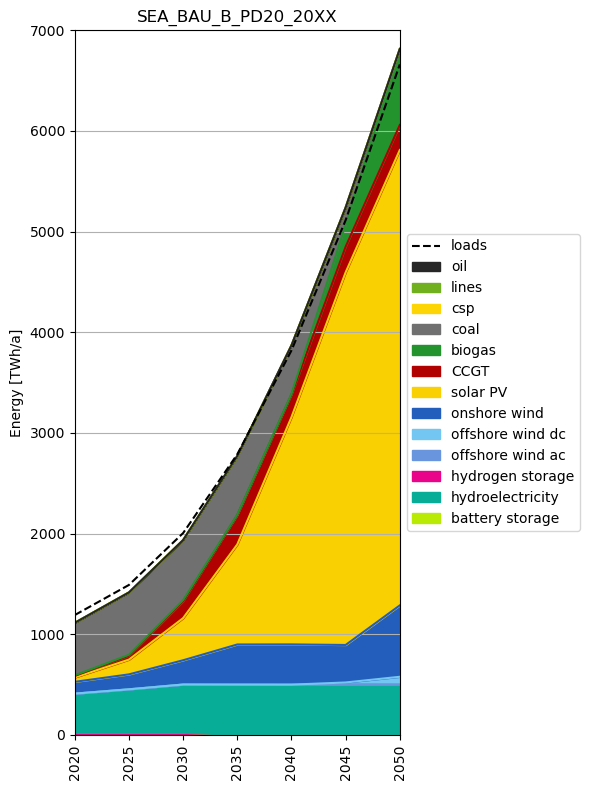

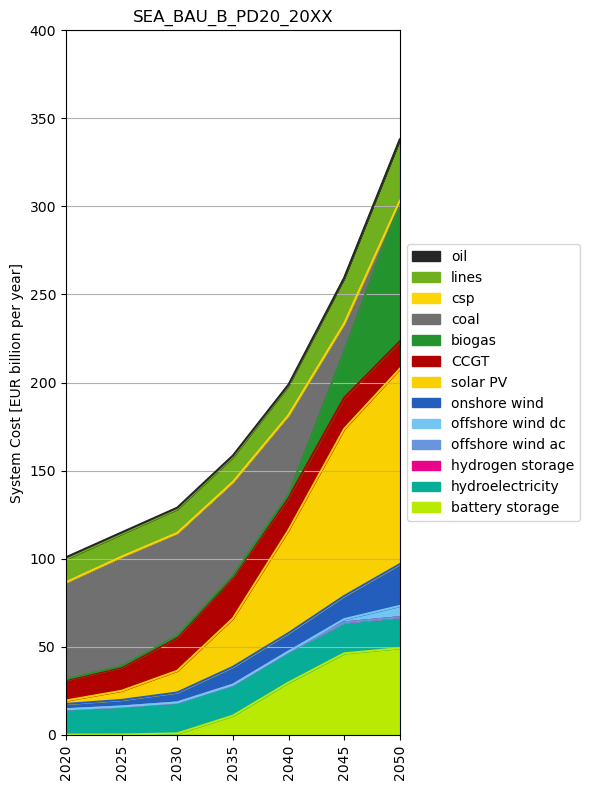

In [24]:
scenario_PyPSA = "SEA_BAU_B_PD20_"
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"
infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}
infn[2020] = f"../{folder_name}/results/SEA_BAU_B_2020/summaries/{network_name}_{country}/{compare}.csv"

df_plot = plot_energy(infn, scenario_PyPSA, config)
renewable_energy = df_plot.loc[["hydroelectricity","solar PV","onshore wind","offshore wind ac","offshore wind dc"],2050].sum()
renewable_share = (renewable_energy/df_plot.loc[:,2050].sum())*100
print(f"renewable share in 2050 is {renewable_share}%")

backup_energy = df_plot.loc[["biogas"],2050].sum()
backup_share = (backup_energy/df_plot.loc[:,2050].sum())*100
print(f"backup share in 2050 is {backup_share}%")

compare = "costs"
infn = {year:f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv" for year in years}
infn[2020] = f"../{folder_name}/results/SEA_BAU_B_2020/summaries/{network_name}_{country}/{compare}.csv"

df_cost = plot_costs(infn, scenario_PyPSA, config)
system_cost = df_cost.loc[:,2050].sum()
print(f"system cost in 2050 is {system_cost}%")

# Test Phase Down 30 Model

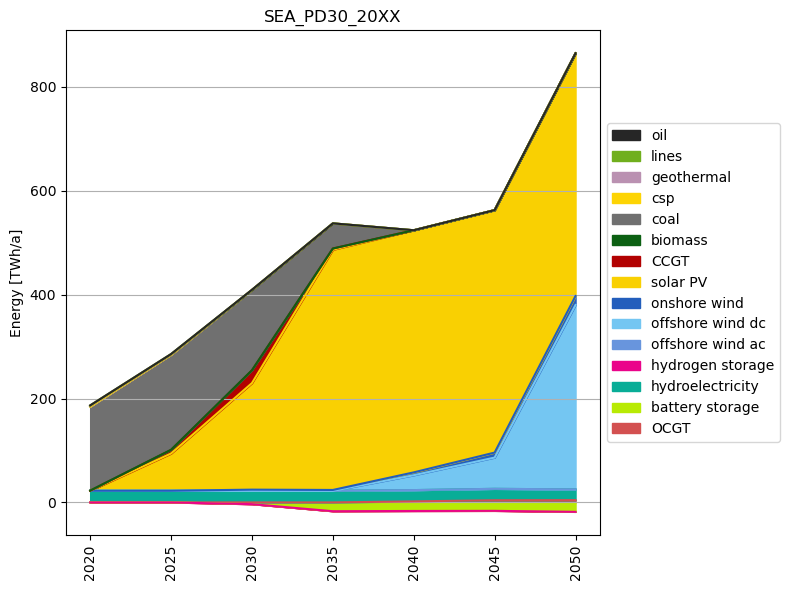

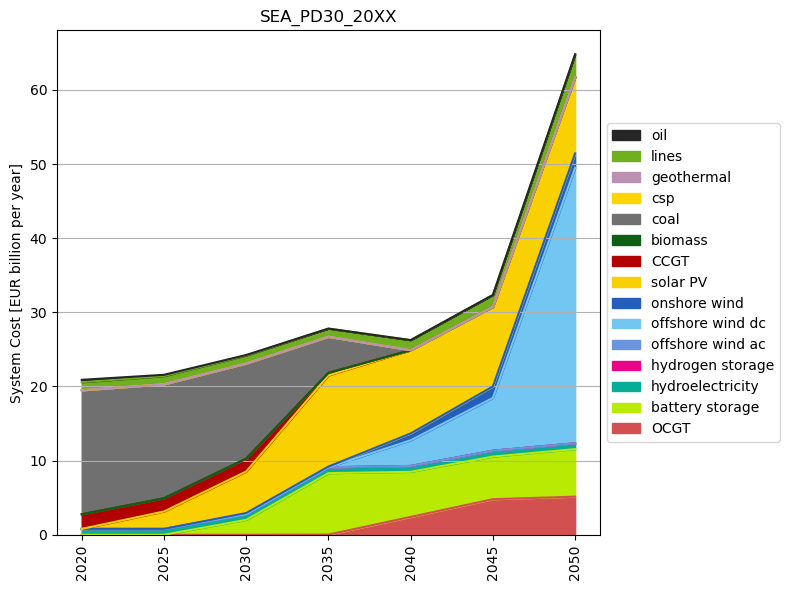

In [9]:
scenario_PyPSA = "SEA_PD30_"
folder_name = "pypsa-earth-preliminary-results_V1"
network_name = "elec_s_200_ec_lcopt_3H"

years = [2025,2030,2035,2040,2045,2050]

country = "Java-Bali/ID" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}
folder_name = "pypsa-earth-preliminary-results_V1"
infn[f"../{folder_name}/results/SEA_BAU_2020/summaries/{network_name}_{country}/{compare}.csv"] = 2020

plot_energy(infn, scenario_PyPSA, config)

compare = "costs"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}
folder_name = "pypsa-earth-preliminary-results_V1"
infn[f"../{folder_name}/results/SEA_BAU_2020/summaries/{network_name}_{country}/{compare}.csv"] = 2020

plot_costs(infn, scenario_PyPSA, config)

# Test Phase Down 20 Model

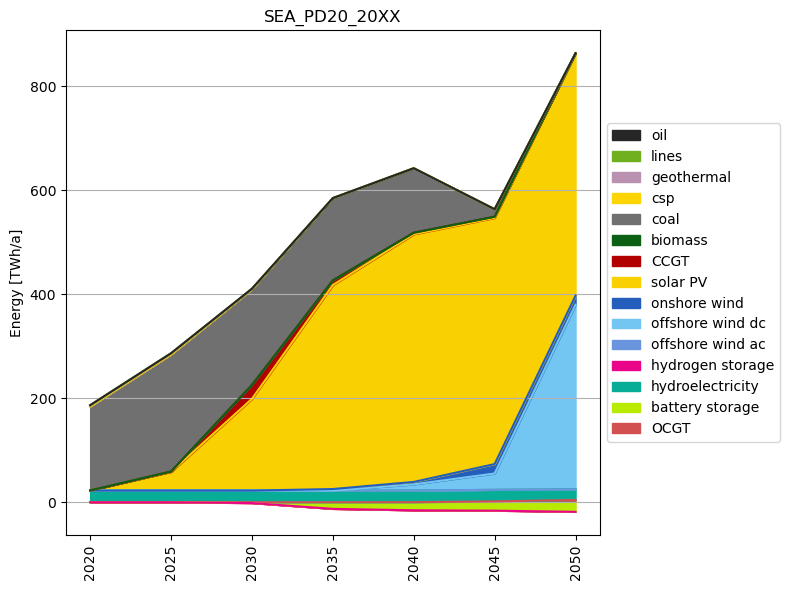

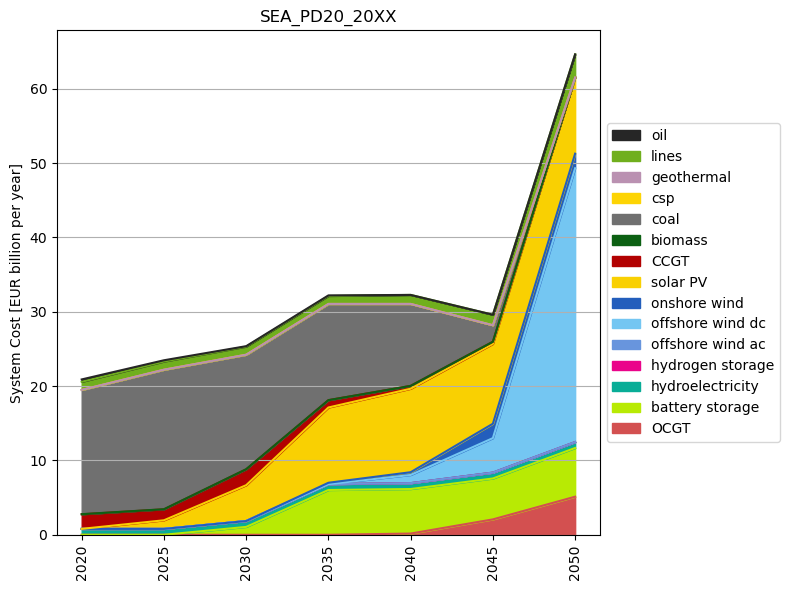

In [10]:
scenario_PyPSA = "SEA_PD20_"
folder_name = "pypsa-earth-preliminary-results_V1"
network_name = "elec_s_200_ec_lcopt_3H"

years = [2025,2030,2035,2040,2045,2050]

country = "Java-Bali/ID" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}
folder_name = "pypsa-earth-preliminary-results_V1"
infn[f"../{folder_name}/results/SEA_BAU_2020/summaries/{network_name}_{country}/{compare}.csv"] = 2020

plot_energy(infn, scenario_PyPSA, config)

compare = "costs"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}
folder_name = "pypsa-earth-preliminary-results_V1"
infn[f"../{folder_name}/results/SEA_BAU_2020/summaries/{network_name}_{country}/{compare}.csv"] = 2020

plot_costs(infn, scenario_PyPSA, config)

# Test Phase Down 10 Model

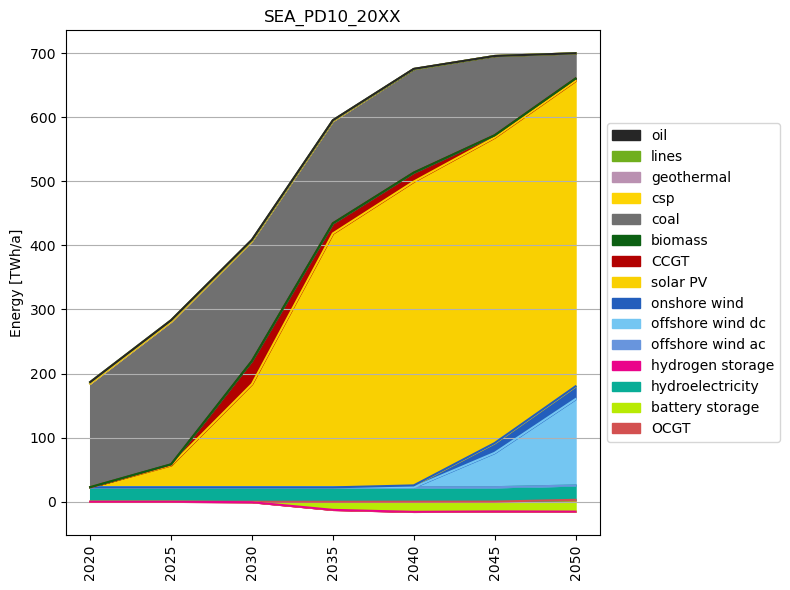

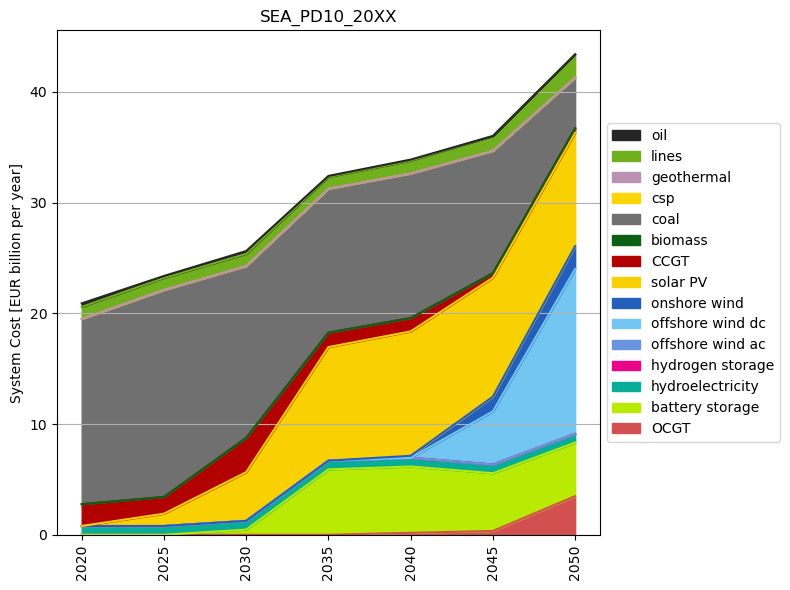

In [11]:
scenario_PyPSA = "SEA_PD10_"
folder_name = "pypsa-earth-preliminary-results_V1"
network_name = "elec_s_200_ec_lcopt_3H"

years = [2025,2030,2035,2040,2045,2050]

country = "Java-Bali/ID" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}
folder_name = "pypsa-earth-preliminary-results_V1"
infn[f"../{folder_name}/results/SEA_BAU_2020/summaries/{network_name}_{country}/{compare}.csv"] = 2020

plot_energy(infn, scenario_PyPSA, config)

compare = "costs"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}
folder_name = "pypsa-earth-preliminary-results_V1"
infn[f"../{folder_name}/results/SEA_BAU_2020/summaries/{network_name}_{country}/{compare}.csv"] = 2020

plot_costs(infn, scenario_PyPSA, config)

# Extended Model

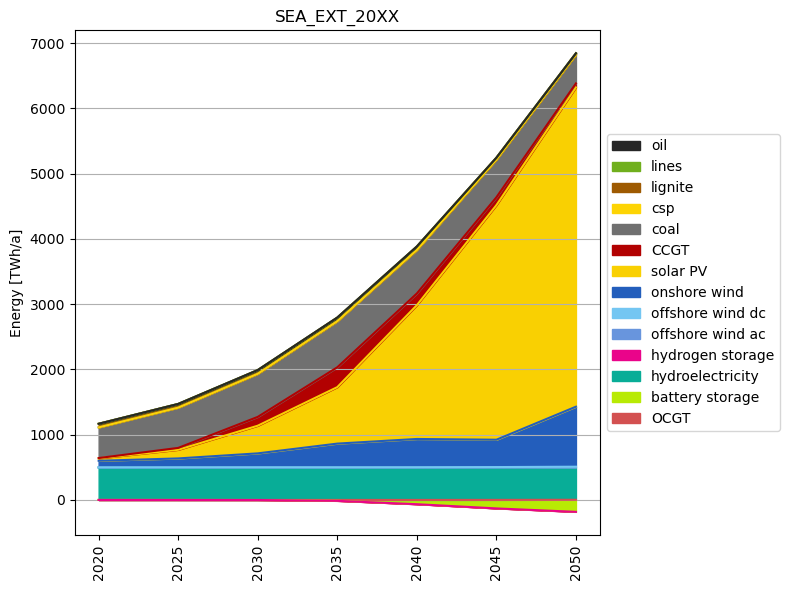

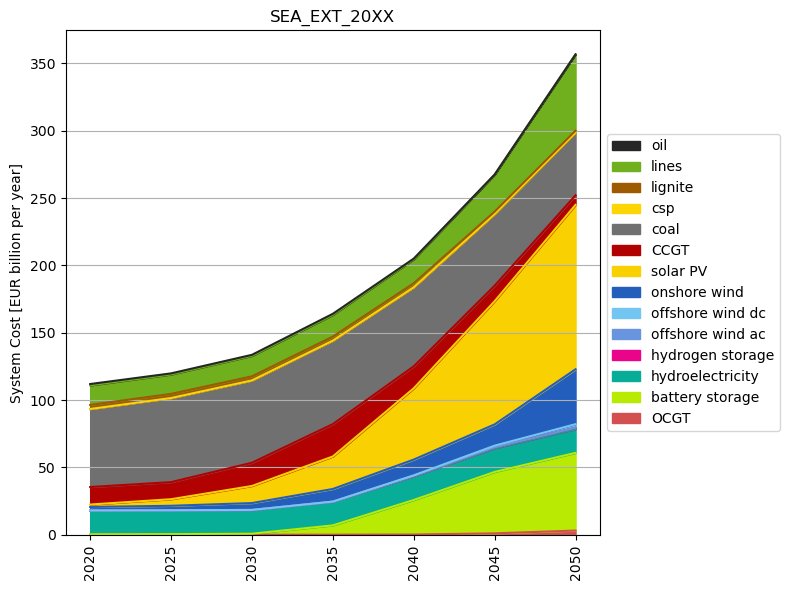

In [19]:
scenario_PyPSA = "SEA_EXT_"
folder_name = "pypsa-earth-preliminary-results_V1"
network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}

plot_energy(infn, scenario_PyPSA, config)

compare = "costs"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}

plot_costs(infn, scenario_PyPSA, config)

# BAU Model

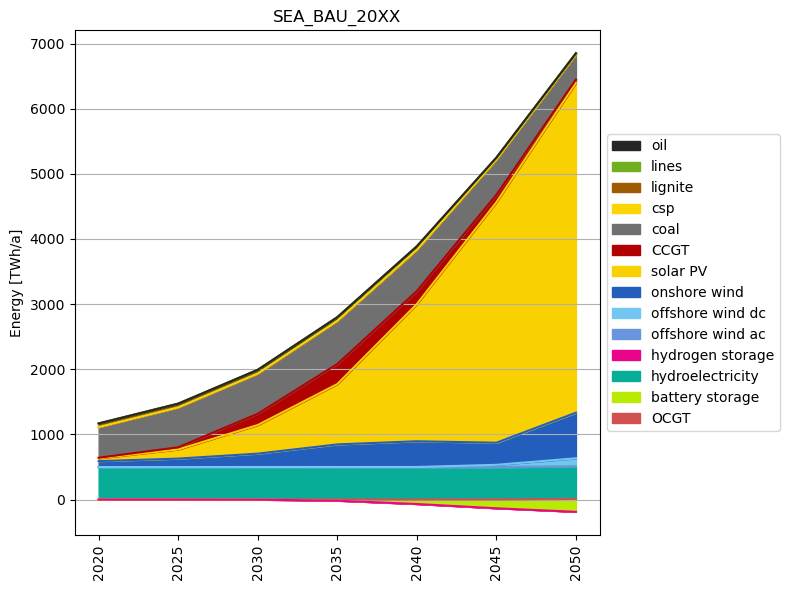

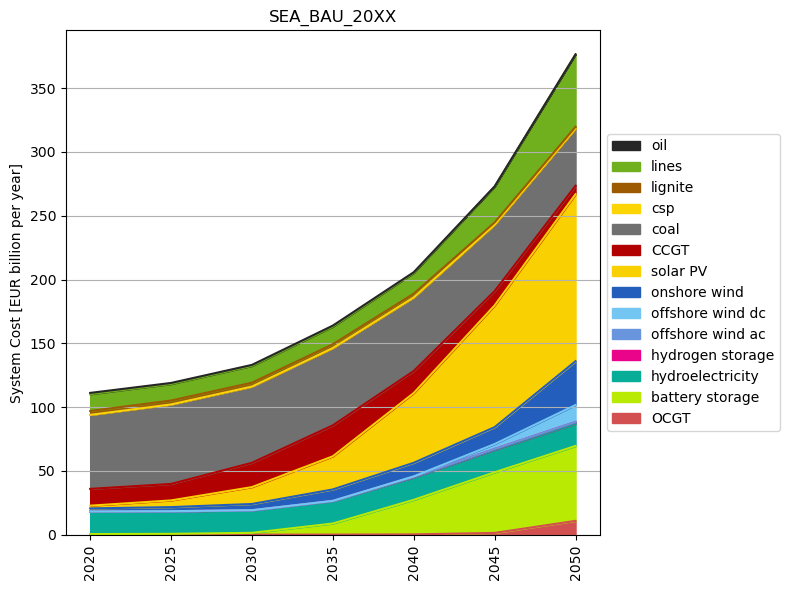

In [20]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth-preliminary-results_V1"
network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}

plot_energy(infn, scenario_PyPSA, config)

compare = "costs"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}

plot_costs(infn, scenario_PyPSA, config)

# Internal (only) Model

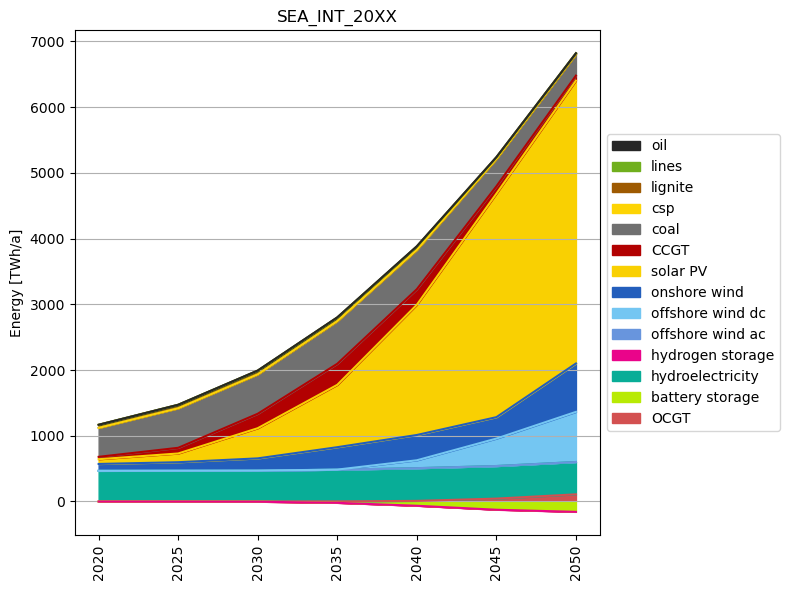

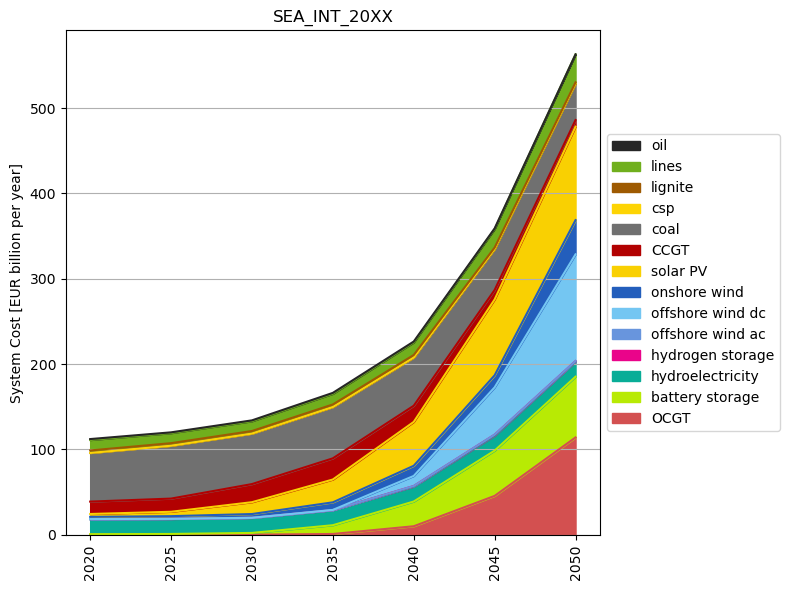

In [21]:
scenario_PyPSA = "SEA_INT_"
folder_name = "pypsa-earth-preliminary-results_V1"
network_name = "elec_s_200_ec_lcopt_3H"

years = [2020,2025,2030,2035,2040,2045,2050]

country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}

plot_energy(infn, scenario_PyPSA, config)

compare = "costs"
infn = {f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name}_{country}/{compare}.csv":year for year in years}

plot_costs(infn, scenario_PyPSA, config)

# Test Energy Autarchy

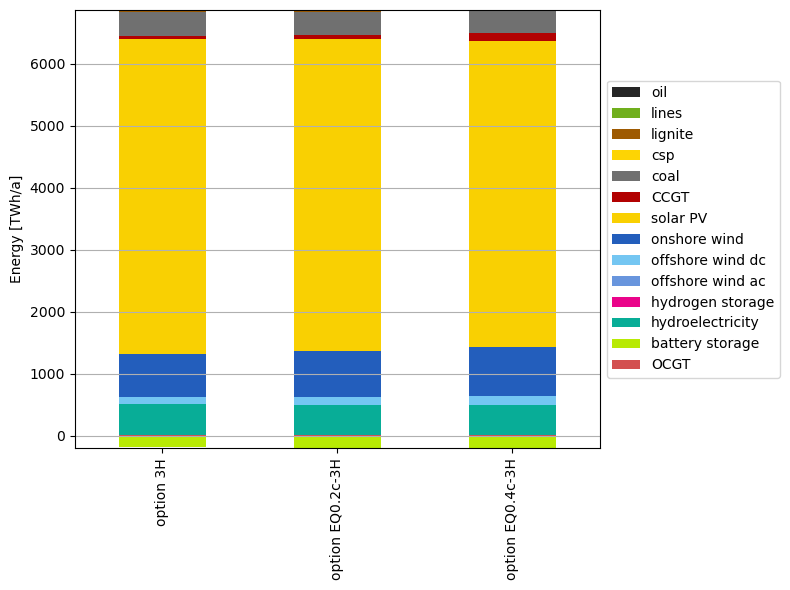

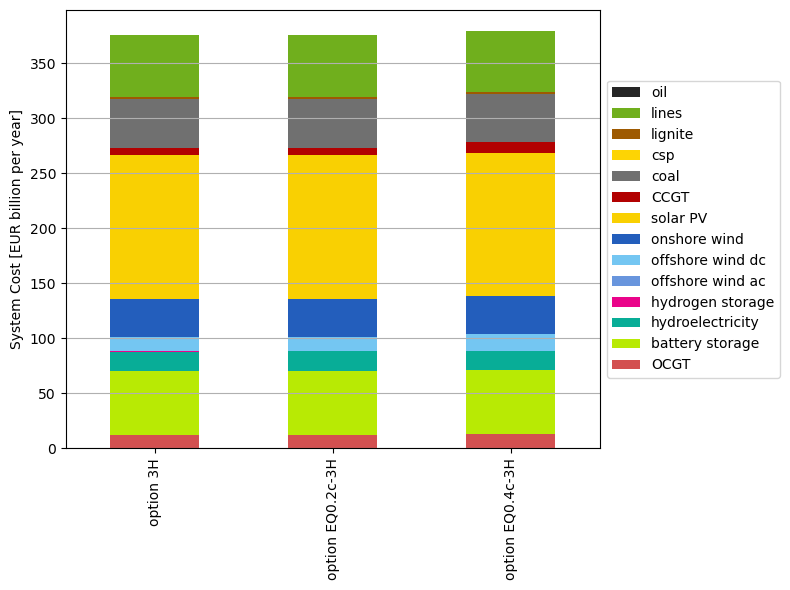

In [11]:
scenario_PyPSA = "SEA_BAU_IRENA_"
network_name = "elec_s_200_ec_lcopt_"
folder_name = "pypsa-earth"

opts = {"3H","EQ0.2c-3H","EQ0.4c-3H"}

year = 2050
country = "all" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"
infn={f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name + str(opt)}_{country}/{compare}.csv":f"option {str(opt)}" for opt in opts}

plot_energy(infn, config, fn=None)

compare = "costs"
infn={f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/{network_name + str(opt)}_{country}/{compare}.csv":f"option {str(opt)}" for opt in opts}

plot_costs(infn, config, fn=None)

# Test backup

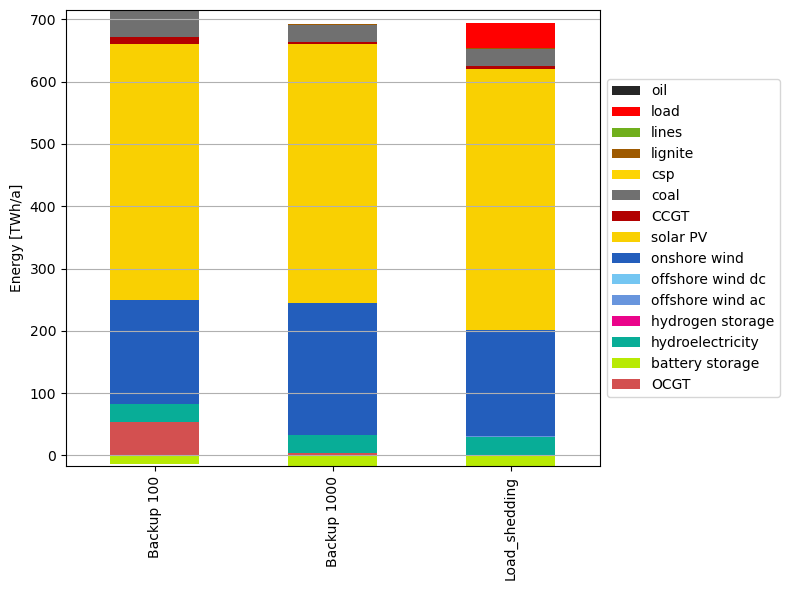

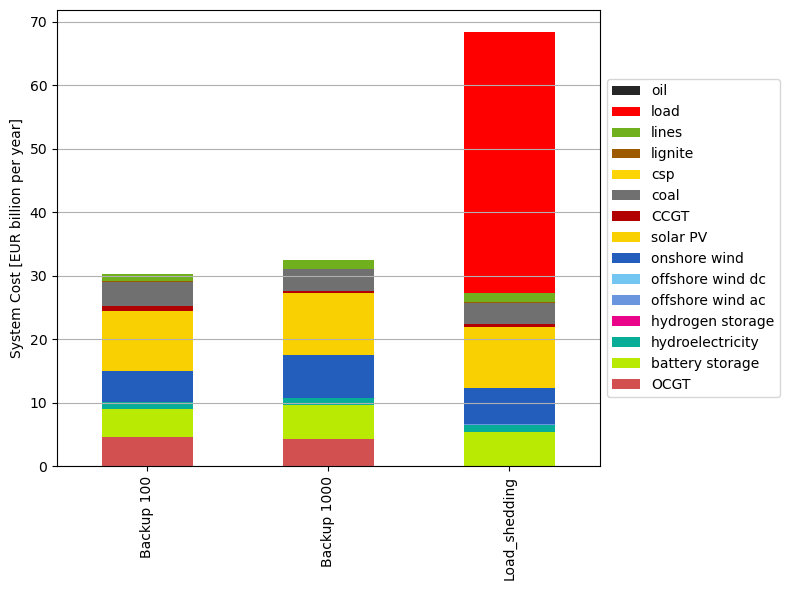

In [6]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L"

year = 2050
country = "PH" # "all","BN","KH","ID","LA","MY","MM","PH","SG","TH","VN"

compare = "energy"
infn = {}
scenario_PyPSA = "SEA_backup"
folder_name = "pypsa-earth-archive-July-2024"
infn[f"../{folder_name}/results/{scenario_PyPSA}/summaries/elec_s_200_ec_lcopt_3H_{country}/{compare}.csv"] = "Backup 100"

scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth"
infn[f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/elec_s_200_ec_lcopt_3H_{country}/{compare}.csv"] = "Backup 1000"

scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth-preliminary-results_V1"
infn[f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/elec_s_200_ec_lcopt_3H_{country}/{compare}.csv"] = "Load_shedding"

plot_energy(infn, config, fn=None)

compare = "costs"
infn = {}
scenario_PyPSA = "SEA_backup"
folder_name = "pypsa-earth-archive-July-2024"
infn[f"../{folder_name}/results/{scenario_PyPSA}/summaries/elec_s_200_ec_lcopt_3H_{country}/{compare}.csv"] = "Backup 100"

scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth"
infn[f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/elec_s_200_ec_lcopt_3H_{country}/{compare}.csv"] = "Backup 1000"

scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth-preliminary-results_V1"
infn[f"../{folder_name}/results/{scenario_PyPSA + str(year)}/summaries/elec_s_200_ec_lcopt_3H_{country}/{compare}.csv"] = "Load_shedding"
plot_costs(infn, config, fn=None)